1. 对宝可梦数据集进行数据分析。  
Tips: 可参考以下问题进行分析，也可自行选取角度进行分析。  
（1）宝可梦的整体平均性别占比为何？  
（2）宝可梦体型（身高，体重）分布为何？  
（3）不同世代的宝可梦数量分布为何？  
（4）比较不同世代的宝可梦水平（基础攻击，基础防御，特殊攻击，特殊防御，速度等）。  
（5）宝可梦的类型（type1，type2）分布如何？  
（6）传奇宝可梦的数量是多少？  
2. 建立一个分类器来识别传奇宝可梦，并且选取合适的指标分析与评估模型效果  

In [1]:
import requests
import re
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, log_loss, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# 描述性统计
def describe(dataframe, features):
    output = pd.DataFrame(columns=('Variable', 'Count', 'Mean', 'Minimum', 'Median', 'Max', 'Std.Error'))

    for feature in features:
        rec = pd.Series({
            'Variable':feature,
            'Count':int(dataframe[[feature]].count()),
            'Mean':dataframe[feature].mean(),
            'Minimum':dataframe[feature].min(),
            'Median':dataframe[feature].median(),
            'Max':dataframe[feature].max(),
            'Std.Error':dataframe[feature].std()
        })
        output = output.append(rec, ignore_index=True)

    display(output)

# 查找缺失
def showLose(df, detail=False):
    if np.any(df.isnull()):
        # 每个属性缺失的数量统计
        lose_static = df.isnull().sum(axis=0)

        # 显示有缺失的属性
        display(lose_static[lose_static!=0])
        print("存在 %d 行空值" %len(df[df.isnull().any(axis=1)]))

        # 显示缺失的详细信息
        if detail:
            # info = ['name','japanese_name']
            info = ['name']
            ls = list(lose_static[lose_static!=0].index)
            for i in info:
                if i in ls:
                    ls.remove(i)
            display(df[df.isnull().any(axis=1)][info+ls])
    else:
        print('无空值')

# 寻找缺失值
def findLose(df, echo=True):
    lose_index = df[df.isnull().any(axis=1)].index
    result = [] # 收集结果

    for n in lose_index:
        code = '%03d' %n
        url = 'https://www.pokemon.cn/play/pokedex/'+code
        resp=requests.get(url)
        if echo:
            print('编号', code, resp) #打印请求结果的状态码
        
        if '200' in str(resp):
            s=str(resp.content)

            # print(re.search(r'<p class="pokemon-slider__main-no size-28">[0-9]*?</p>', s))
            # print(re.search(r'<p class="pokemon-slider__main-name size-35">[\s\S]*?</p>', s))
            # print(re.search(r'<span class="pokemon-info__value size-14">[\S]*? m</span>', s))
            # print(re.search(r'<span class="pokemon-info__value size-14">[\S]*? kg</span>', s))

            numberstr = re.search(r'<p class="pokemon-slider__main-no size-28">[0-9]*?</p>', s).group(0)
            heightstr = re.search(r'<span class="pokemon-info__value size-14">[\S]*? m</span>', s).group(0)
            weightstr = re.search(r'<span class="pokemon-info__value size-14">[\S]*? kg</span>', s).group(0)

            number = numberstr[43:-4]
            height = heightstr[42:-9]
            weight = weightstr[42:-10]

            # print(number, height, weight)

            result += [[number, height, weight]]

    return result

# 1.1 导入数据、修改列名错误、查看数据类型

In [3]:
pokemon = pd.read_csv('./pokemon.csv')
print(pokemon.columns)
# classification拼写错误，修正便于后期调用
pokemon = pokemon.rename(columns={'classfication':'classification'})
print(pokemon.drop(columns = pokemon.filter(regex='against_').columns).dtypes)
# against_*过多，为float64，不作显示

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')
abilities             object
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classification        object
defense                int64
experience_growth      int64
height_m             f

capture_rate是object型，需要后续检查

In [4]:
pokemon.head().T

,0,1,2,3,4
abilities,"['Overgrow', 'Chlorophyll']","['Overgrow', 'Chlorophyll']","['Overgrow', 'Chlorophyll']","['Blaze', 'Solar Power']","['Blaze', 'Solar Power']"
against_bug,1.0,1.0,1.0,0.5,0.5
against_dark,1.0,1.0,1.0,1.0,1.0
against_dragon,1.0,1.0,1.0,1.0,1.0
against_electric,0.5,0.5,0.5,1.0,1.0
against_fairy,0.5,0.5,0.5,0.5,0.5
against_fight,0.5,0.5,0.5,1.0,1.0
against_fire,2.0,2.0,2.0,0.5,0.5
against_flying,2.0,2.0,2.0,1.0,1.0
against_ghost,1.0,1.0,1.0,1.0,1.0


# 1.2 检查空值
无性别和单属性必然有空值，不考虑  

In [5]:
showLose(pokemon.drop(['percentage_male','type2'], axis=1), detail=True)

height_m     20
weight_kg    20
dtype: int64

存在 20 行空值


,name,height_m,weight_kg
18,Rattata,NaN,NaN
19,Raticate,NaN,NaN
25,Raichu,NaN,NaN
26,Sandshrew,NaN,NaN
27,Sandslash,NaN,NaN
36,Vulpix,NaN,NaN
37,Ninetales,NaN,NaN
49,Diglett,NaN,NaN
50,Dugtrio,NaN,NaN
51,Meowth,NaN,NaN


In [6]:
# Pokedex编号无空值，直接作为索引
pokemon.set_index('pokedex_number', inplace=True)

# 1.3 填充空值
使用简单的爬虫或者已查询到的本地数据

In [7]:
# 是否使用口袋图鉴爬虫
use_pokedex = False
if use_pokedex:
    result = findLose(pokemon.drop(['percentage_male','type2'], axis=1), echo=True)

# 否则使用本地数据
else:
    result=[['019', '0.3', '3.5'], 
    ['020', '0.7', '18.5'], 
    ['026', '0.8', '30.0'], 
    ['027', '0.6', '12.0'], 
    ['028', '1.0', '29.5'], 
    ['037', '0.6', '9.9'], 
    ['038', '1.1', '19.9'], 
    ['050', '0.2', '0.8'], 
    ['051', '0.7', '33.3'], 
    ['052', '0.4', '4.2'], 
    ['053', '1.0', '32.0'], 
    ['074', '0.4', '20.0'], 
    ['075', '1.0', '105.0'], 
    ['076', '1.4', '300.0'], 
    ['088', '0.9', '30.0'], 
    ['089', '1.2', '30.0'], 
    ['103', '2.0', '120.0'], 
    ['105', '1.0', '45.0'], 
    ['720', '0.5', '9.0'], 
    ['745', '0.8', '25.0']]

# 整合输出结果为DataFrame
fill = pd.DataFrame(result)
fill.columns=['index', 'height_m', 'weight_kg']
fill['index']=fill['index'].astype('int')
fill['height_m']=fill['height_m'].astype('float64')
fill['weight_kg']=fill['weight_kg'].astype('float64')
fill.set_index('index', inplace=True)

In [8]:
# 补全空值
pokemon.update(fill, overwrite=False)

In [9]:
# 重新检查空值
print(pokemon.shape)
showLose(pokemon.drop(['percentage_male','type2'], axis=1), detail=True)

(801, 40)
无空值


In [10]:
pokemon['double_type'] = pokemon['type2'].apply(lambda x: 0 if pd.isnull(x) else 1)
pokemon.filter(regex='type').head()

,type1,type2,double_type
pokedex_number,,,
1,grass,poison,1
2,grass,poison,1
3,grass,poison,1
4,fire,NaN,0
5,fire,NaN,0


## 已知问题：小陨星的捕获率
根据Pokedex，小陨星（Meteorite，流星的样子）捕获率为30，小陨星（Core，颜色核心）捕获率为255。  
根据其他属性，判断该行为小陨星（Core，颜色核心），应改为255

In [11]:
print(pokemon['capture_rate'].unique())
print(pokemon[pokemon['capture_rate']=='30 (Meteorite)255 (Core)'].index.tolist())
display(pokemon[pokemon['capture_rate']=='30 (Meteorite)255 (Core)'])
pokemon.loc[774,'capture_rate']='255'
pokemon['capture_rate']=pokemon['capture_rate'].astype('int64')
pokemon['capture_rate'].dtypes

['45' '255' '120' '127' '90' '190' '75' '235' '150' '25' '170' '50' '200'
 '100' '180' '60' '225' '30' '35' '3' '65' '70' '125' '205' '155' '145'
 '130' '140' '15' '220' '160' '80' '55' '30 (Meteorite)255 (Core)']
[774]


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,double_type
pokedex_number,,,,,,,,,,,,,,,,,,,,,
774,['Shields Down'],0.5,1.0,1.0,2.0,1.0,1.0,0.5,0.5,1.0,...,NaN,100,60,120,rock,flying,40.0,7,0,1


dtype('int64')

# 2.1 数据概览

In [12]:
print('条目', pokemon.shape[0])
print('类型', pokemon['classification'].unique().shape[0])
print('双属性', pokemon[~pokemon['type2'].isnull()].shape[0])

fp = pokemon.filter(regex='against_')
print('属性抵抗', fp.drop_duplicates().shape[0])
fp = pokemon.filter(regex='type')
print('属性', fp.drop_duplicates().shape[0])
fp = pokemon.filter(regex='against_').join(pokemon.filter(regex='type'))
print('属性抵抗+属性', fp.drop_duplicates().shape[0])

print('传奇', pokemon['is_legendary'].agg('sum'))

条目 801
类型 588
双属性 417
属性抵抗 135
属性 166
属性抵抗+属性 166
传奇 70


可以看出 
类型较多，具有特异性，分析的效果不明显
双属性宝可梦几乎占一半
**属性组合**的数量166多于**属性抵抗组合**的数量135，且**属性抵抗+属性**组合后的数量和属性数量相同，为166  
说明：属性决定属性抵抗，且存在不同属性组合有相同属性的属性抵抗分布的情况。

考虑到第一第二属性有顺序问题，因此需要忽略顺序问题再次进行统计  

其他信息：有些双属性组合只有唯一的宝可梦  

In [13]:
def genTypeGroup(series):
    if pd.isnull(series['type2']):
        return series['type1']
    else:
        ls = series.values.tolist()
        ls.sort()
        return ''.join(ls)

pokemon['typegroup']=pokemon[['type1','type2']].apply(genTypeGroup, axis=1)

In [14]:
fp = pokemon.filter(regex='against_')
print('属性抵抗', fp.drop_duplicates().shape[0])
fp = pokemon.filter(regex='typegroup')
print('无顺序属性组合', fp.drop_duplicates().shape[0])
fp = pokemon.filter(regex='against_').join(pokemon.filter(regex='typegroup'))
print('属性抵抗+无顺序属性', fp.drop_duplicates().shape[0])

属性抵抗 135
无顺序属性组合 142
属性抵抗+无顺序属性 144


忽略顺序之后，无顺序属性和属性抵抗+无顺序属性的组合差2，可能有问题

# 2.2 已知问题：宝可梦属性错误标注
027 穿山鼠，028 穿山王，为地面属性（阿罗拉的样子为冰+钢）  
105 嘎啦嘎啦，为地面属性（阿罗拉的样子为火+幽灵）

In [15]:
# 检查函数，传入一个待查属性，或加一个对比属性，以及是否去重开关
def typeTest(*typegroups, duplicates: bool):
    if len(typegroups)==1:
        typegroup1 = typegroups[0]
        df = pokemon[pokemon['typegroup']==typegroup1]

    elif len(typegroups)==2:
        typegroup1 = typegroups[0]
        typegroup2 = typegroups[1]
        df = pd.concat([pokemon[pokemon['typegroup']==typegroup1],pokemon[pokemon['typegroup']==typegroup2]],axis=0)

    df = df.filter(regex='against_').join(df.filter(regex='type'))
    if duplicates:
        print('属性抵抗+无顺序属性', df.shape[0])
        return df.T
    else:
        print('属性抵抗+无顺序属性', df.drop_duplicates().shape[0])
        return df.drop_duplicates().T

In [16]:
# 检查144和142的差异
superDF = pokemon.filter(regex='against_').join(pokemon.filter(regex='typeg')).drop_duplicates()
subDF = pokemon.filter(regex='typeg').drop_duplicates()
superlist = superDF.index.tolist()
sublist = subDF.index.tolist()
for i in sublist:
    superlist.remove(i)
print(superlist)

[220, 322]


In [17]:
pokemon.loc[superlist,:]

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,double_type,typegroup
pokedex_number,,,,,,,,,,,,,,,,,,,,,
220,"['Oblivious', 'Snow Cloak', 'Thick Fat']",1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,...,30,30,50,ice,ground,6.5,2,0,1,groundice
322,"['Oblivious', 'Simple', 'Own Tempo']",0.5,1.0,1.0,0.0,0.5,1.0,0.5,1.0,1.0,...,65,45,35,fire,ground,24.0,3,0,1,fireground


这两列地面+火/冰的属性和防御组合不同于其他

In [18]:
# 检查地面和地面+火属性
test = typeTest('ground', 'fireground', duplicates=True)
test

属性抵抗+无顺序属性 13


pokedex_number,104,231,232,328,383,449,450,529,749,750,105,322,323
against_bug,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5
against_dark,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dragon,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_electric,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
against_fairy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5
against_fight,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_fire,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.5
against_flying,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_ghost,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_grass,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0


看出105号地面+火不同于322和323，反而与地面系相同，查询知105为嘎啦嘎啦

In [19]:
# 修正
pokemon.loc[105,'type2'] = np.nan

In [20]:
# 检查地面和地面+冰属性
test = typeTest('ground', 'groundice', duplicates=True)
test

属性抵抗+无顺序属性 15


pokedex_number,104,231,232,328,383,449,450,529,749,750,27,28,220,221,473
against_bug,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dark,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dragon,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_electric,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
against_fairy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_fight,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
against_fire,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
against_flying,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_ghost,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_grass,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


看出27、28号地面+冰不同于220、221和473，反而与地面系相同，查询知027为穿山鼠，028为穿山王

In [21]:
# 修正
pokemon.loc[27,'type2'] = np.nan
pokemon.loc[28,'type2'] = np.nan

In [22]:
# 刷新typegroup和double_type
pokemon['typegroup']=pokemon[['type1','type2']].apply(genTypeGroup, axis=1)
pokemon['double_type'] = pokemon['type2'].apply(lambda x: 0 if pd.isnull(x) else 1)

# 2.3 已知问题：双属性错误

In [23]:
superDF = pokemon.filter(regex='typegroup').drop_duplicates()
subDF = pokemon.filter(regex='against_').drop_duplicates()
superlist = superDF.index.tolist()
sublist = subDF.index.tolist()
for i in sublist:
    superlist.remove(i)
print(superlist)

[26, 37, 50, 88, 108, 492, 555]


In [24]:
pokemon.loc[superlist,:].T

pokedex_number,26,37,50,88,108,492,555
abilities,"['Static', 'Lightningrod', 'Surge Surfer']","['Flash Fire', 'Drought', 'Snow Cloak', 'Snow ...","['Sand Veil', 'Arena Trap', 'Sand Force', 'San...","['Stench', 'Sticky Hold', 'Poison Touch', 'Poi...","['Own Tempo', 'Oblivious', 'Cloud Nine']","['Natural Cure', 'Serene Grace']","['Sheer Force', 'Zen Mode']"
against_bug,1.0,0.5,1.0,0.5,1.0,2.0,0.5
against_dark,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dragon,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_electric,0.5,1.0,0.0,1.0,1.0,0.5,1.0
against_fairy,1.0,0.5,1.0,0.5,1.0,1.0,0.5
against_fight,1.0,1.0,1.0,0.5,2.0,1.0,1.0
against_fire,1.0,0.5,1.0,1.0,1.0,2.0,0.5
against_flying,0.5,1.0,1.0,1.0,1.0,2.0,1.0
against_ghost,1.0,1.0,1.0,1.0,0.0,1.0,1.0


发现存在一些双属性相同的错误

In [25]:
# 修正
pokemon['type2'] = pokemon[['type1','type2']].apply(lambda x: np.nan if x['type1']==x['type2'] else x['type2'], axis=1)

# 2.4 已知问题：属性错误
037 六尾为火属性（阿罗拉的样子为冰属性）  
038 九尾为火属性（阿罗拉的样子为冰+妖精属性）  
019 小拉达为普通属性  
020 拉达为普通属性  
052 喵喵为普通属性  
053 猫老大为普通属性  

In [26]:
# 检查火+冰属性
test = typeTest('fire', 'fireice', duplicates=True)
test

属性抵抗+无顺序属性 29


pokedex_number,4,5,58,59,77,78,126,136,155,156,...,513,514,554,631,653,654,725,726,37,38
against_bug,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
against_dark,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dragon,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_electric,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_fairy,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
against_fight,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_fire,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
against_flying,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_ghost,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_grass,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


看出37号，38号火+冰与火属性相同，查询知37，38为六尾和九尾

In [27]:
# 修正
pokemon.loc[37,'type2'] = np.nan
pokemon.loc[38,'type2'] = np.nan

## 检查108号被错误属性排斥为重复值的情况

In [28]:
# 在136组合内查属性抵抗组合的重复，将108置顶
fp = pokemon.filter(regex='against_')
t = fp.loc[[108]+sublist,:]
t[t.duplicated()].T

pokedex_number,19
against_bug,1.0
against_dark,1.0
against_dragon,1.0
against_electric,1.0
against_fairy,1.0
against_fight,2.0
against_fire,1.0
against_flying,1.0
against_ghost,0.0
against_grass,1.0


In [29]:
# 得到了属性错误编号为19
pokemon.loc[[19],:]

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,double_type,typegroup
pokedex_number,,,,,,,,,,,,,,,,,,,,,
19,"['Run Away', 'Guts', 'Hustle', 'Gluttony', 'Hu...",1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,...,25,35,72,normal,dark,3.5,1,0,1,darknormal


In [30]:
# 检查普通属性
test = typeTest('darknormal','normal', duplicates=True)
test

属性抵抗+无顺序属性 65


pokedex_number,19,20,52,53,108,113,115,128,132,133,...,572,573,626,659,676,734,735,772,773,775
against_bug,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dark,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_dragon,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_electric,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_fairy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_fight,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
against_fire,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_flying,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
against_ghost,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
against_grass,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


看出19，20，52，53号普通+恶与普通属性相同，查询知19，20，52，53为小拉达，拉达，喵喵，猫老大（阿罗拉的样子具有恶属性）

In [31]:
# 修正
pokemon.loc[19,'type2'] = np.nan
pokemon.loc[20,'type2'] = np.nan
pokemon.loc[52,'type2'] = np.nan
pokemon.loc[53,'type2'] = np.nan

In [32]:
# 刷新typegroup和double_type
pokemon['typegroup']=pokemon[['type1','type2']].apply(genTypeGroup, axis=1)
pokemon['double_type'] = pokemon['type2'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [33]:
fp = pokemon.filter(regex='against_')
print('属性抵抗', fp.drop_duplicates().shape[0])
fp = pokemon.filter(regex='typegroup')
print('无顺序属性组合', fp.drop_duplicates().shape[0])
fp = pokemon.filter(regex='against_').join(pokemon.filter(regex='typegroup'))
print('属性抵抗+无顺序属性', fp.drop_duplicates().shape[0])

属性抵抗 135
无顺序属性组合 135
属性抵抗+无顺序属性 135


## 修正基本完成
说明第一到第七世代宝可梦共产生了135种属性组合（包括单属性）  
宝可梦规律：一种属性组合的属性防御完全相同，因此修正后against_*的18个特征完全对应typegroup，可以予以忽略

In [34]:
df = pokemon.drop(columns=pokemon.filter(regex='against_').columns)
# 能力和分类繁杂且无普遍规律，予以忽略
df = df.drop(columns=['abilities', 'classification'])
# df.to_excel('pokemonfixed.xlsx')

In [35]:
df.head().T

pokedex_number,1,2,3,4,5
attack,49,62,100,52,64
base_egg_steps,5120,5120,5120,5120,5120
base_happiness,70,70,70,70,70
base_total,318,405,625,309,405
capture_rate,45,45,45,45,45
defense,49,63,123,43,58
experience_growth,1059860,1059860,1059860,1059860,1059860
height_m,0.7,1.0,2.0,0.6,1.1
hp,45,60,80,39,58
japanese_name,Fushigidaneフシギダネ,Fushigisouフシギソウ,Fushigibanaフシギバナ,Hitokageヒトカゲ,Lizardoリザード


# 3.1 分析方案
如何分类同一种不同形态的宝可梦？技能不同，类型也不同，也有同技能同类型属于不同种宝可梦的  
Tips: 可参考以下问题进行分析，也可自行选取角度进行分析。  
**（1）宝可梦的整体平均性别占比为何？**  
性别：整体性别；不同世代性别；不同属性（不区分第一第二属性）性别，单双属性性别  
**（2）宝可梦体型（身高，体重）分布为何？**  
身高体重：整体；不同世代；不同属性（不区分第一第二属性），单双属性  
BMI：整体；不同世代；不同属性（不区分第一第二属性），单双属性  
**（3）不同世代的宝可梦数量分布,不同世代的单双属性分布**  
数量：不同世代  
单双属性：不同世代  
各种单属性的世代分布  
**（4）比较不同世代的宝可梦水平（基础攻击，基础防御，特殊攻击，特殊防御，速度等）。**  
能力-雷达图+条形：HP，基础攻击，基础防御，特殊攻击，特殊防御，速度  
培养-条形：捕获率，基本步数，能力，经验增长，基础幸福感  

用性别分布再做一遍
**（5）宝可梦的类型（type1，type2）分布如何？**  
**（6）传奇宝可梦的数量是多少？**  
总数，不同世代  
传奇的属性统计，性别，**身高，体重，BMI，雷达，条形**（可与普通作比较）  

In [36]:
# 描述性统计
describe(df, ['percentage_male', 'weight_kg', 'height_m',
       'capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth', 
       'hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense', 'base_total', 
       'double_type', 'is_legendary'])

,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,percentage_male,703,5.515576e+01,0.0,50.0,100.0,20.261623
1,weight_kg,801,6.094120e+01,0.1,27.3,999.9,108.514597
2,height_m,801,1.155556e+00,0.1,1.0,14.5,1.069952
3,capture_rate,801,9.895630e+01,3.0,60.0,255.0,76.409828
4,base_egg_steps,801,7.191011e+03,1280.0,5120.0,30720.0,6558.220422
5,base_happiness,801,6.536205e+01,0.0,70.0,140.0,19.598948
6,experience_growth,801,1.054996e+06,600000.0,1000000.0,1640000.0,160255.835096
7,hp,801,6.895880e+01,1.0,65.0,255.0,26.576015
8,speed,801,6.633458e+01,5.0,65.0,180.0,28.907662
9,attack,801,7.785768e+01,5.0,75.0,185.0,32.158820


## 3.2 数量分布

<AxesSubplot:title={'center':'不同世代的宝可梦数量'}, xlabel='generation'>

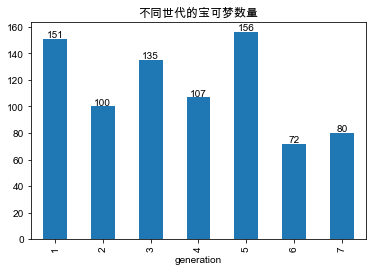

In [37]:
plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
df1 = df.groupby('generation')['generation'].count()
for x,y in enumerate(df1):
    plt.text(x,y+1,'%s' %y,ha='center')
df1.plot.bar(title='不同世代的宝可梦数量')

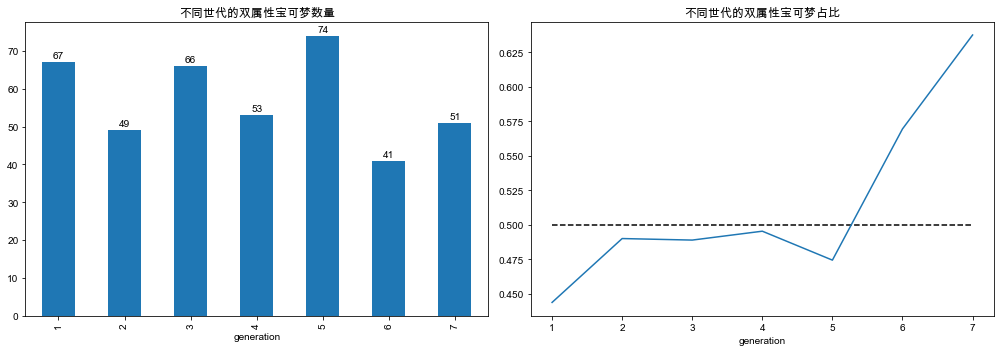

In [38]:
fig = plt.figure(figsize=(14, 5), facecolor='w')

fig.add_subplot(1,2,1)
df1 = df.groupby('generation')['double_type'].agg('sum')
for x,y in enumerate(df1):
    plt.text(x,y+1,'%s' %y,ha='center')
df1.plot.bar(title='不同世代的双属性宝可梦数量')

fig.add_subplot(1,2,2)
plt.plot([1,7],[0.5,0.5],'k--')
df.groupby('generation')['double_type'].agg('mean').plot(title='不同世代的双属性宝可梦占比')

fig.tight_layout()

In [39]:
def typeis(df, type):
    return df[['type1','type2']].isin([type]).any(axis=1)
    # 返回一个布尔序列

types = df[df['double_type']==0]['type1'].unique()

In [40]:
df1.head()

generation
1    67
2    49
3    66
4    53
5    74
Name: double_type, dtype: int64

Text(0, 0.5, '数量')

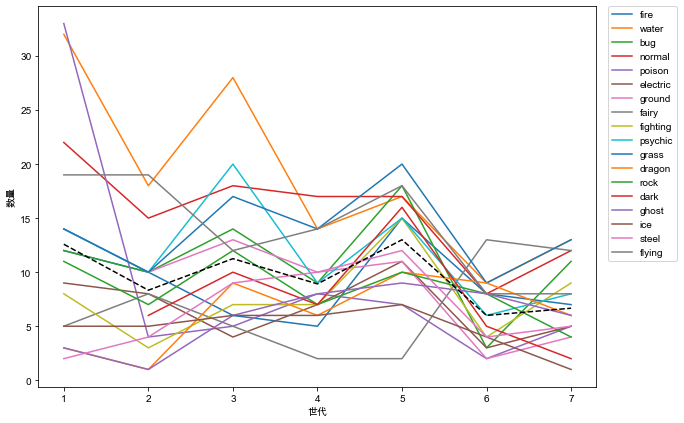

In [41]:
fig = plt.figure(figsize=(10,7))
df1=pd.DataFrame()
for type in types:
    df1[type] = df[typeis(df, type)].groupby('generation')['generation'].count()
# df1.plot(title='不同世代出现的属性数量')
plt.plot(df1)
plt.legend(df1.columns.tolist(), loc=2, bbox_to_anchor=(1.02,1),borderaxespad = 0.)

df2 = df.groupby('generation')['generation'].count()*1.5/18
plt.plot(df2, 'k--')
plt.xlabel('世代')
plt.ylabel('数量')

## 3.3 性别分布

<AxesSubplot:xlabel='percentage_male'>

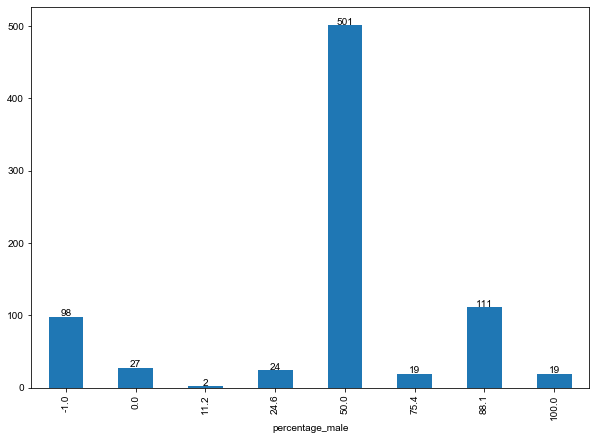

In [42]:
# 总体性别分布
fig = plt.figure(figsize=(10,7))
df1 = df[['percentage_male']]
df1 = df1.fillna(-1)
df1 = df1.groupby('percentage_male')['percentage_male'].count()
for x,y in enumerate(df1):
    plt.text(x,y+1,'%s' %y,ha='center')
df1.plot.bar()

<AxesSubplot:xlabel='generation'>

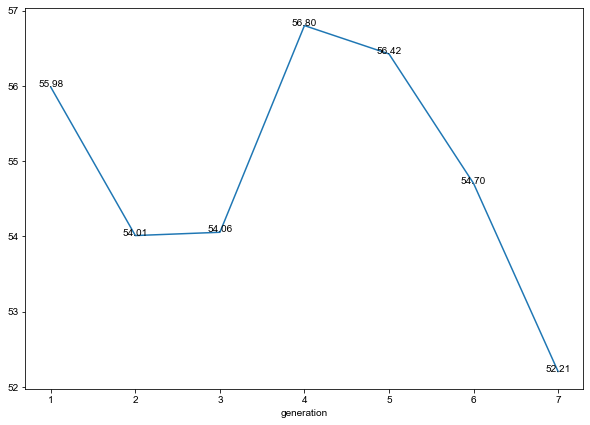

In [43]:
# 世代性别分布
fig = plt.figure(figsize=(10,7))
gender_gen_distribution = df.groupby('generation')['percentage_male'].agg('mean')
for x,y in enumerate(gender_gen_distribution):
    plt.text(x+1,y,'%.2f' %y,ha='center')
gender_gen_distribution.plot()

(-10.0, 120.0)

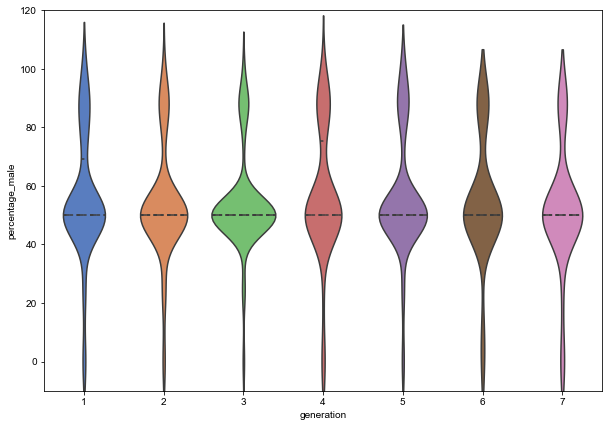

In [44]:
# 世代性别分布(小提琴图)
fig = plt.figure(figsize=(10,7))
sns.violinplot(x='generation', y='percentage_male', data=df, palette="muted", split=True, inner="quartile")
plt.ylim(-10,120)

<AxesSubplot:xlabel='percentage_male'>

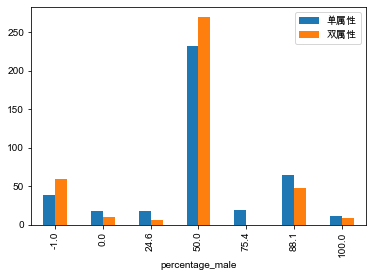

In [45]:
# 单双属性性别分布
df1 = df[['percentage_male','generation','double_type']]
df1 = df1.fillna(-1)
gender_distribution = pd.DataFrame()
gender_distribution['单属性'] = df1[df1['double_type']==0].groupby('percentage_male')['percentage_male'].count()
gender_distribution['双属性'] = df1[df1['double_type']==1].groupby('percentage_male')['percentage_male'].count()
gender_distribution.plot.bar()

<AxesSubplot:xlabel='generation'>

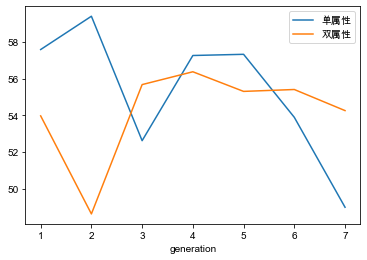

In [46]:
# 单双属性世代性别分布
gender_distribution = pd.DataFrame()
gender_distribution['单属性'] = df[df['double_type']==0].groupby('generation')['percentage_male'].agg('mean')
gender_distribution['双属性'] = df[df['double_type']==1].groupby('generation')['percentage_male'].agg('mean')
gender_distribution.plot()

第二世代双属性的平均雄性占比出现小于50的情况

Text(0, 0.5, '雄性宝可梦性别比例（排序）')

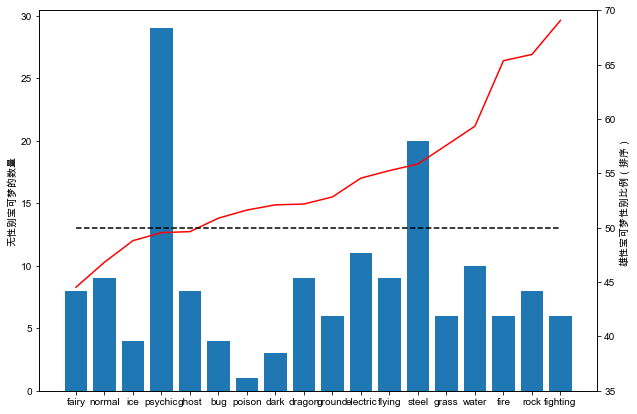

In [47]:
# 属性的性别分布
df1=pd.DataFrame()
for type in types:
    mean = df[typeis(df, type)]['percentage_male'].mean()
    no_gender = df[typeis(df, type)]['percentage_male'].isnull().sum()
    df1[type] = [mean, no_gender]
df1 = df1.T
df1.columns=['mean', 'no_gender']
df1 = df1.sort_values(by='mean')

fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot()
ax1.bar(df1.index, df1['no_gender'])
ax1.set_ylabel('无性别宝可梦的数量')

ax2 = ax1.twinx()
ax2.plot(df1['mean'], c='red')
ax2.plot([0,17],[50,50], 'k--')
ax2.set_ylim((35,70))
ax2.set_ylabel('雄性宝可梦性别比例（排序）')

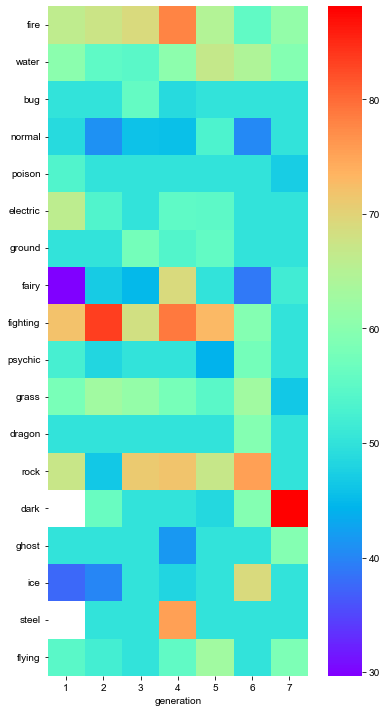

In [48]:
fig = plt.figure(figsize=(6,10))
df1=pd.DataFrame()
for type in types:
    df1[type] = df[typeis(df, type)].groupby('generation')['percentage_male'].agg('mean')
sns.heatmap(df1.T, cmap="rainbow", square=True)
fig.tight_layout()

## 3.4 身高、体重分布
加入BMI计算(人类BMI的正常范围为18.5-23.9)

Text(0, 0.5, '体重')

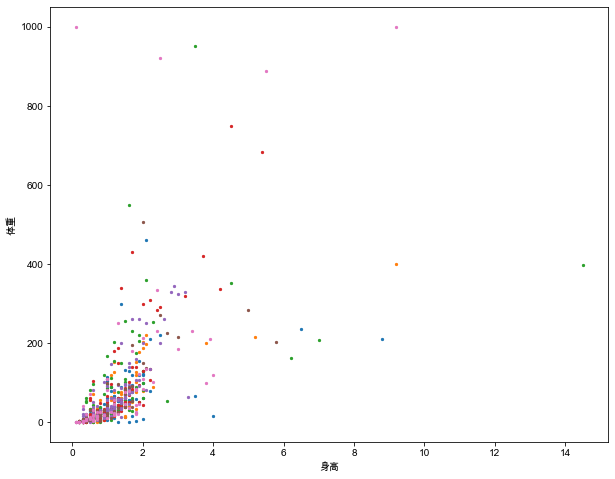

In [49]:
plt.figure(figsize=(10,8))
# for type in types:
#     plt.scatter(df[df['is_'+type]==1]['height_m'], df[df['is_'+type]==1]['weight_kg'])
for g in range(1,8):
    plt.scatter(df[df['generation']==g]['height_m'], df[df['generation']==g]['weight_kg'], s=5)
plt.xlabel('身高')
plt.ylabel('体重')
# plt.xlim(0,2)
# plt.ylim(0,200)

In [50]:
# 计算BMI
df['BMI']=df['weight_kg']/df['height_m']**2

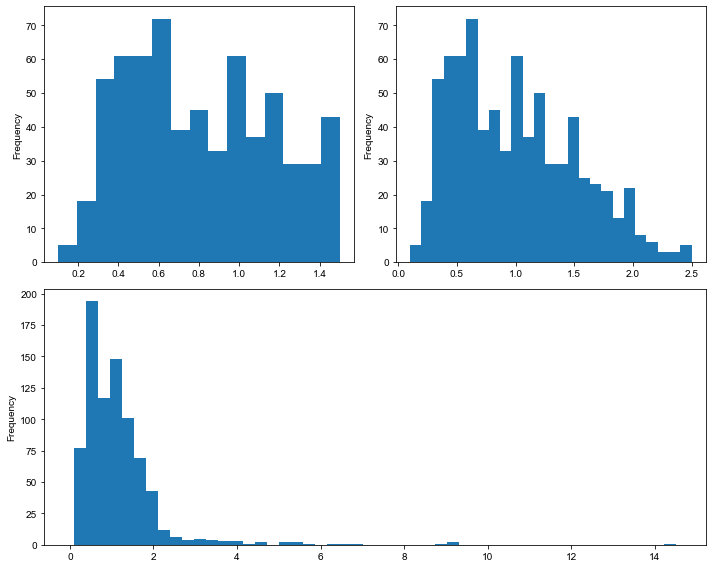

In [51]:
# 身高分布
fig = plt.figure(figsize=(10, 8), facecolor='w')

fig.add_subplot(2,2,1)
df[df['height_m']<=1.5]['height_m'].plot.hist(bins=15)

fig.add_subplot(2,2,2)
df[df['height_m']<=2.5]['height_m'].plot.hist(bins=25)

fig.add_subplot(2,1,2)
df['height_m'].plot.hist(bins=50)

fig.tight_layout()

Text(0.5, 1.0, '世代身高分布')

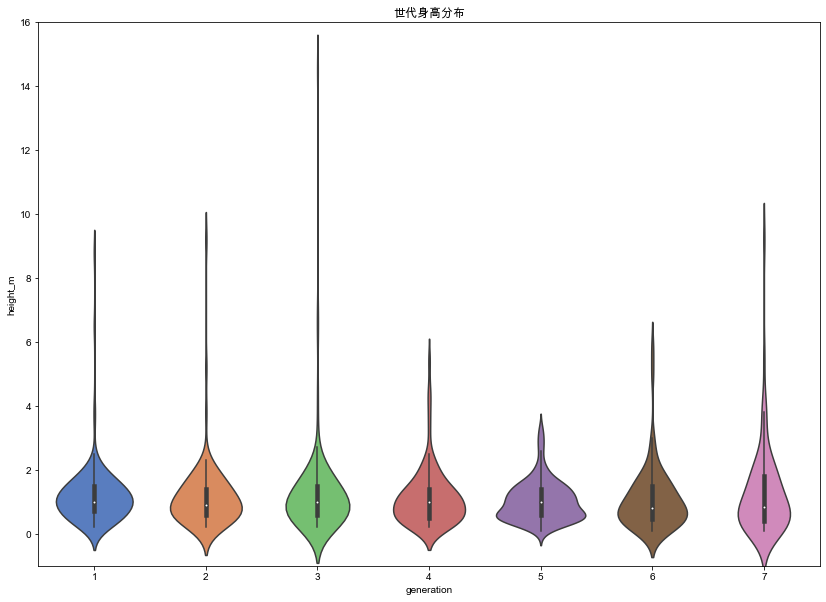

In [52]:
# 世代身高分布
fig = plt.figure(figsize=(14,10))
sns.violinplot(x='generation', y='height_m', data=df, palette="muted", split=True)
plt.ylim(-1,16)
plt.title('世代身高分布')

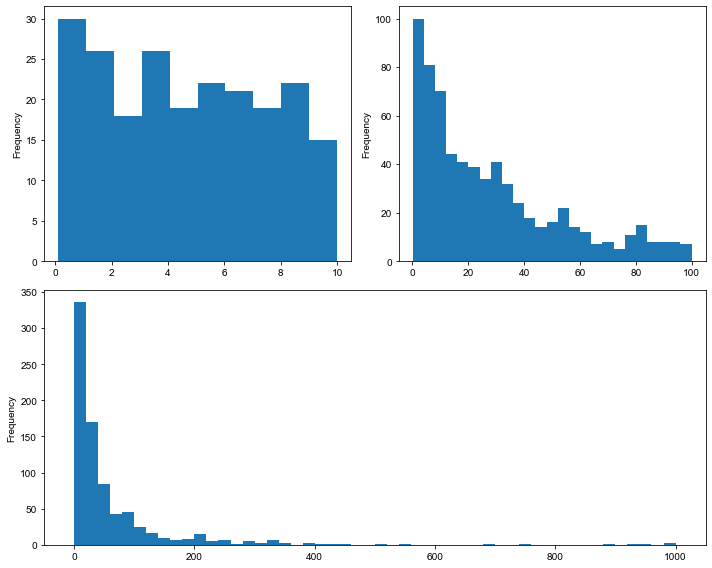

In [53]:
# 体重分布
fig = plt.figure(figsize=(10, 8), facecolor='w')

fig.add_subplot(2,2,1)
df[df['weight_kg']<=10]['weight_kg'].plot.hist(bins=10)

fig.add_subplot(2,2,2)
df[df['weight_kg']<=100]['weight_kg'].plot.hist(bins=25)

fig.add_subplot(2,1,2)
df['weight_kg'].plot.hist(bins=50)

fig.tight_layout()

Text(0.5, 1.0, '世代体重分布')

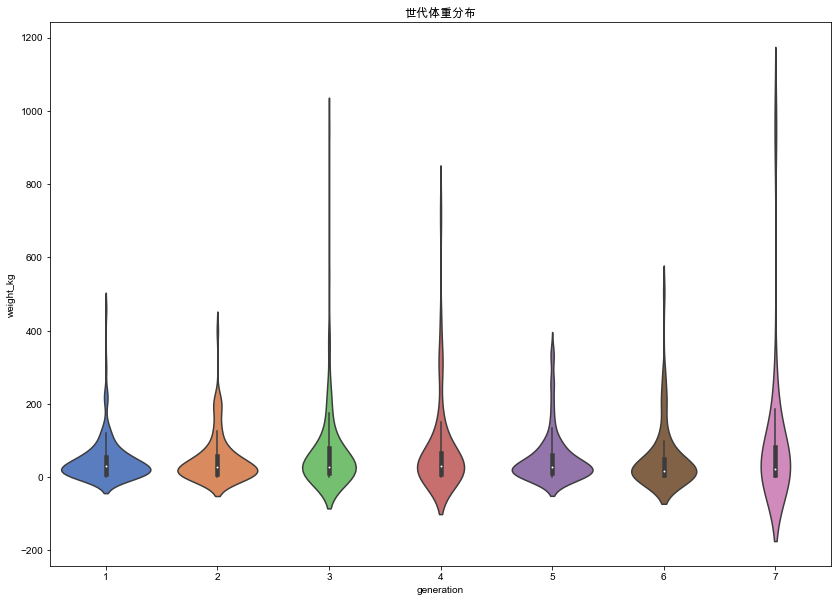

In [54]:
# 世代体重分布
fig = plt.figure(figsize=(14,10))
sns.violinplot(x='generation', y='weight_kg', data=df, palette="muted", split=True)
plt.title('世代体重分布')

In [55]:
df[df['BMI']==df['BMI'].max()] #790号Cosmoem

,attack,base_egg_steps,base_happiness,base_total,capture_rate,defense,experience_growth,height_m,hp,japanese_name,...,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,double_type,typegroup,BMI
pokedex_number,,,,,,,,,,,,,,,,,,,,,
790,29,30720,0,400,45,131,1250000,0.1,43,Cosmovumコスモウム,...,131,37,psychic,NaN,999.9,7,1,0,psychic,99990.0


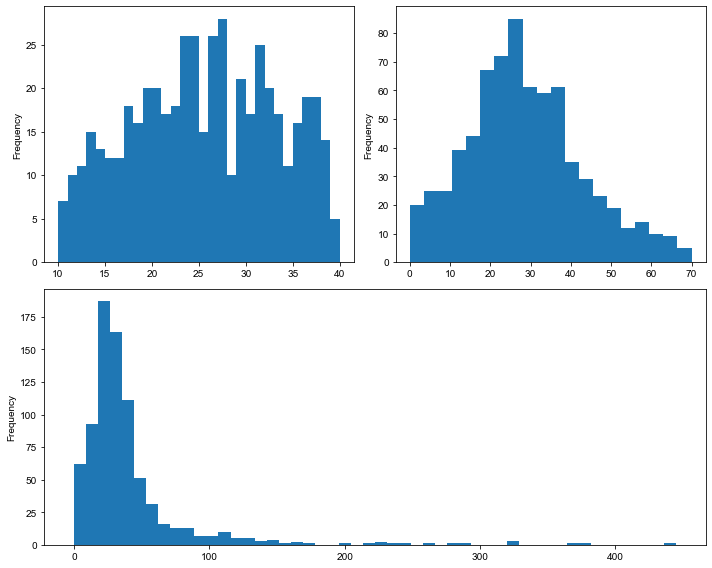

In [56]:
# BMI分布
df1 = df.drop(790)
fig = plt.figure(figsize=(10, 8), facecolor='w')

fig.add_subplot(2,2,1)
df1[df1['BMI'].map(lambda x: True if (x<=40)&(x>=10) else False)]['BMI'].plot.hist(bins=30)

fig.add_subplot(2,2,2)
df1[df1['BMI']<=70]['BMI'].plot.hist(bins=20)

fig.add_subplot(2,1,2)
df1['BMI'].plot.hist(bins=50)

fig.tight_layout()

Text(0.5, 1.0, '世代BMI分布')

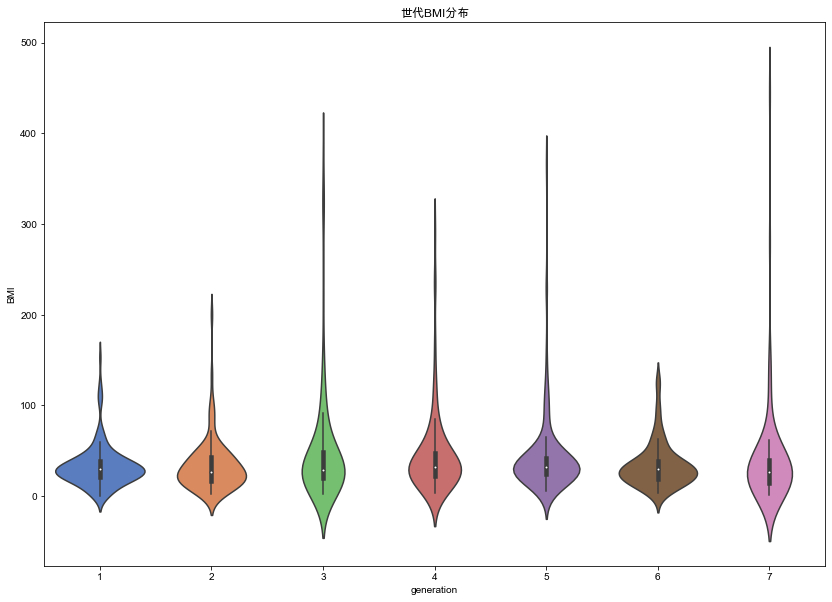

In [57]:
# 世代BMI分布
fig = plt.figure(figsize=(14,10))
sns.violinplot(x='generation', y='BMI', data=df.drop(790), palette="muted", split=True)
plt.title('世代BMI分布')

Text(0.5, 1.0, '单双属性BMI分布(去除790号)')

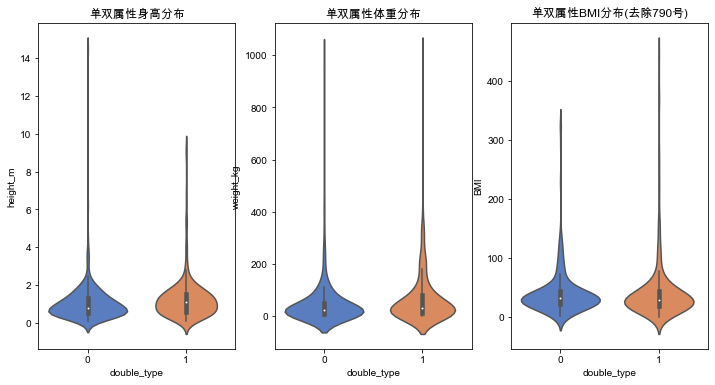

In [58]:
fig = plt.figure(figsize=(12, 6), facecolor='w')
fig.add_subplot(1,3,1)
sns.violinplot(x='double_type', y='height_m', data=df, palette="muted", split=True)
plt.title('单双属性身高分布')

fig.add_subplot(1,3,2)
sns.violinplot(x='double_type', y='weight_kg', data=df, palette="muted", split=True)
plt.title('单双属性体重分布')

fig.add_subplot(1,3,3)
sns.violinplot(x='double_type', y='BMI', data=df.drop(790), palette="muted", split=True)
plt.title('单双属性BMI分布(去除790号)')

In [59]:
# 身高、体重、BMI的属性分布
df1=pd.DataFrame()
for type in types:
    t = df[typeis(df, type)][['height_m','weight_kg','BMI','type1']]
    t['type1'] = type
    df1 = pd.concat([df1, t], axis=0)

(-0.5, 5.0)

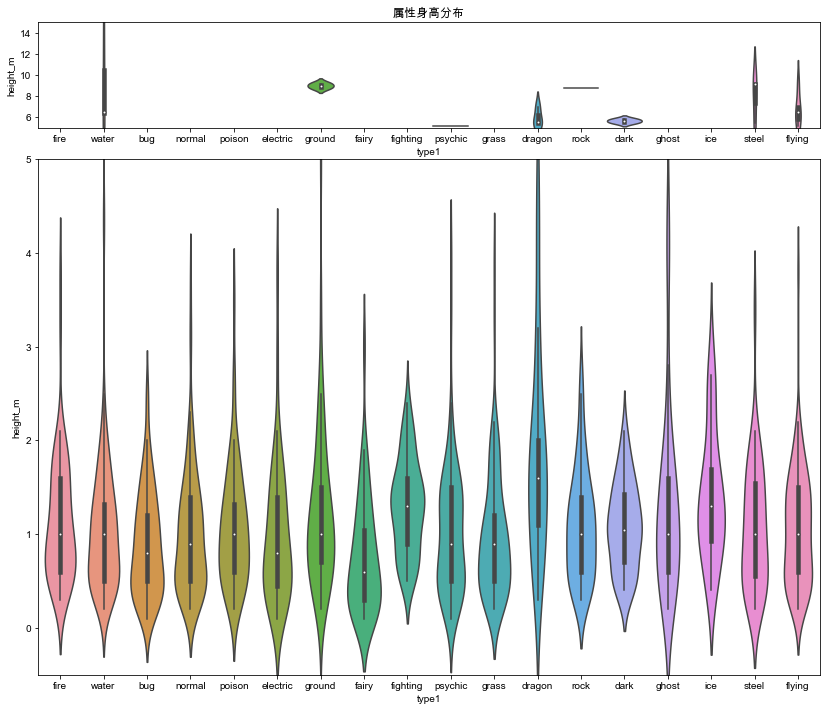

In [60]:
fig = plt.figure(figsize=(14,12))
grid = plt.GridSpec(5, 1, wspace=0.3, hspace=0.3)

fig.add_subplot(grid[0,0])
sns.violinplot(x='type1', y='height_m', data=df1[df1['height_m']>5], split=True, order=df1['type1'].unique())
plt.ylim((5,15))
plt.title('属性身高分布')

fig.add_subplot(grid[1:,0])
sns.violinplot(x='type1', y='height_m', data=df1[df1['height_m']<=5], split=True)
plt.ylim((-0.5,5))

# 此处分割400以上的体重

(-50.0, 400.0)

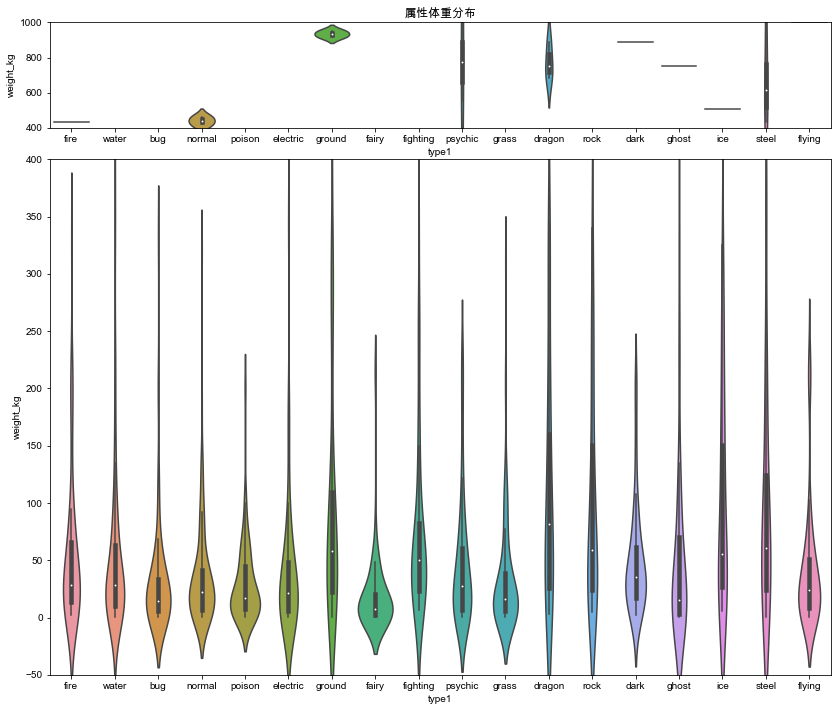

In [61]:
fig = plt.figure(figsize=(14,12))
grid = plt.GridSpec(5, 1, wspace=0.3, hspace=0.3)

fig.add_subplot(grid[0,0])
sns.violinplot(x='type1', y='weight_kg', data=df1[df1['weight_kg']>400], split=True, order=df1['type1'].unique())
plt.ylim((400,1000))
plt.title('属性体重分布')

fig.add_subplot(grid[1:,0])
sns.violinplot(x='type1', y='weight_kg', data=df1[df1['weight_kg']<=400], split=True)
plt.ylim((-50,400))

# 此处分割400以上的体重

(-25.0, 150.0)

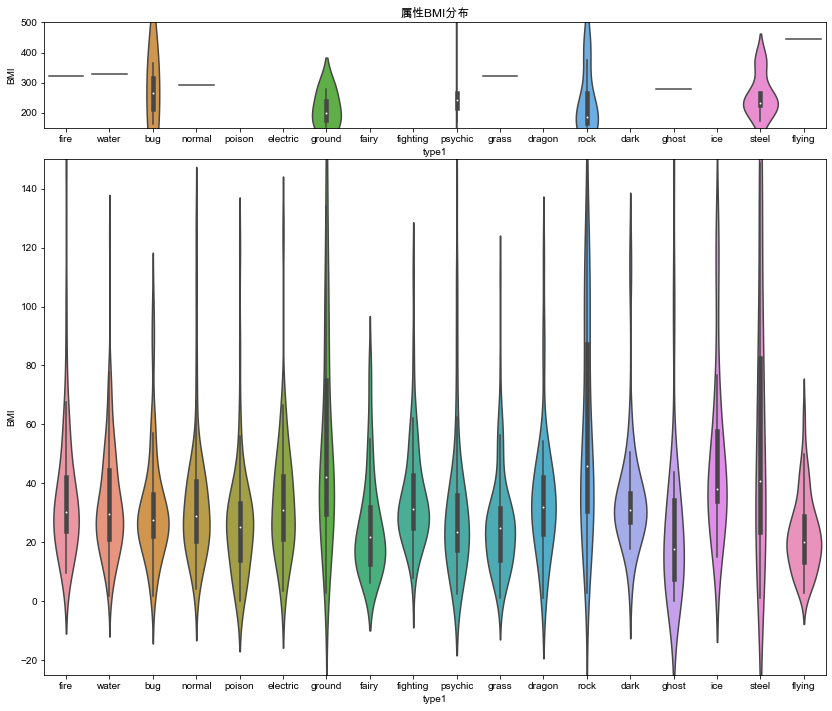

In [62]:
fig = plt.figure(figsize=(14,12))
grid = plt.GridSpec(5, 1, wspace=0.3, hspace=0.3)

fig.add_subplot(grid[0,0])
sns.violinplot(x='type1', y='BMI', data=df1[df1['BMI']>150], split=True, order=df1['type1'].unique())
plt.ylim((150,500))
plt.title('属性BMI分布')

fig.add_subplot(grid[1:,0])
sns.violinplot(x='type1', y='BMI', data=df1[df1['BMI']<=150], split=True)
plt.ylim((-25,150))

# 此处分割400以上的体重

# 3.5 “培养”和“战斗”
培养：捕获率，基本步数，能力，经验增长，基础幸福感  
战斗：HP，基础攻击，基础防御，特殊攻击，特殊防御，速度  

In [63]:
def radarplot(ax, df, rlim, step, title=''):
    dimensions = df.shape[1]
    columns = df.columns.tolist()
    index = df.index.tolist()
    angles = np.linspace(0, 2*np.pi, dimensions, endpoint=False)

    columns = np.concatenate((columns, [columns[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    df = pd.concat([df, df[[columns[0]]]], axis=1)

    for i in index:
        data = df.loc[i,:].tolist()
        ax.plot(angles, data)
    ax.set_thetagrids(angles*180/np.pi, columns[0:dimensions+1], size=15)
    ax.set_theta_zero_location('N')
    ax.set_rlabel_position(0)
    ax.set_rlim(rlim[0], rlim[1])
    for j in np.arange(rlim[0], rlim[1]+step, step):
        ax.plot(angles, (dimensions+1)*[j], '-', lw=0.5, color='grey')
    ax.spines['polar'].set_visible(False)
    ax.grid(False)
    ax.set_title(title)
    plt.legend(index, loc='best')

In [64]:
describe(df, ['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth', 
       'hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense', 'base_total'])

,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,capture_rate,801,9.895630e+01,3,60.0,255,76.409828
1,base_egg_steps,801,7.191011e+03,1280,5120.0,30720,6558.220422
2,base_happiness,801,6.536205e+01,0,70.0,140,19.598948
3,experience_growth,801,1.054996e+06,600000,1000000.0,1640000,160255.835096
4,hp,801,6.895880e+01,1,65.0,255,26.576015
5,speed,801,6.633458e+01,5,65.0,180,28.907662
6,attack,801,7.785768e+01,5,75.0,185,32.158820
7,defense,801,7.300874e+01,5,70.0,230,30.769159
8,sp_attack,801,7.130587e+01,10,65.0,194,32.353826
9,sp_defense,801,7.091136e+01,20,66.0,230,27.942501


In [65]:
print('capture_rate', df['capture_rate'].unique())
print('base_egg_steps', df['base_egg_steps'].unique())
print('base_happiness', df['base_happiness'].unique())
print('experience_growth', df['experience_growth'].unique())

capture_rate [ 45 255 120 127  90 190  75 235 150  25 170  50 200 100 180  60 225  30
  35   3  65  70 125 205 155 145 130 140  15 220 160  80  55]
base_egg_steps [ 5120  3840  2560  6400 10240  1280  8960  7680 20480 30720]
base_happiness [ 70 140  35   0 100  90]
experience_growth [1059860 1000000  800000 1250000 1640000  600000]


虽然“培养”型数据形式上是连续型数据，但根据官方设定，大多取值都是固定的几类。并且，经验和培养步数数值量级较大，但可缩放到与其他数据相同的0～255范围内。

In [66]:
df1 = df[['generation','capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']].copy()
df1['base_egg_steps'] = df1['base_egg_steps']/df1['base_egg_steps'].max()*240
df1['experience_growth'] = df1['experience_growth']/10000
describe(df1, df1.columns)

,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,generation,801,3.690387,1,4.0,7,1.930420
1,capture_rate,801,98.956305,3,60.0,255,76.409828
2,base_egg_steps,801,56.179775,10.0,40.0,240.0,51.236097
3,base_happiness,801,65.362047,0,70.0,140,19.598948
4,experience_growth,801,105.499591,60.0,100.0,164.0,16.025584


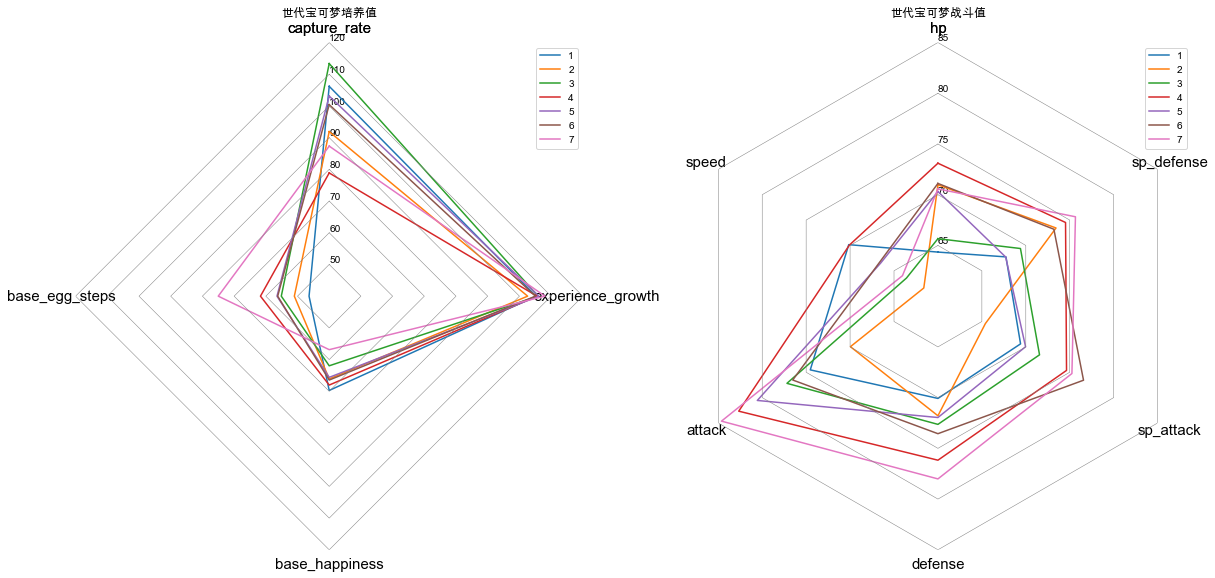

In [67]:
fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(121, polar=True)
df1 = df1.groupby('generation')[['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']].agg('mean')
radarplot(ax1, df1, rlim=[40, 120], step=10, title='世代宝可梦培养值')

ax2 = plt.subplot(122, polar=True)
df2 = df.groupby('generation')[['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].agg('mean')
radarplot(ax2, df2, rlim=[60, 85], step=5, title='世代宝可梦战斗值')

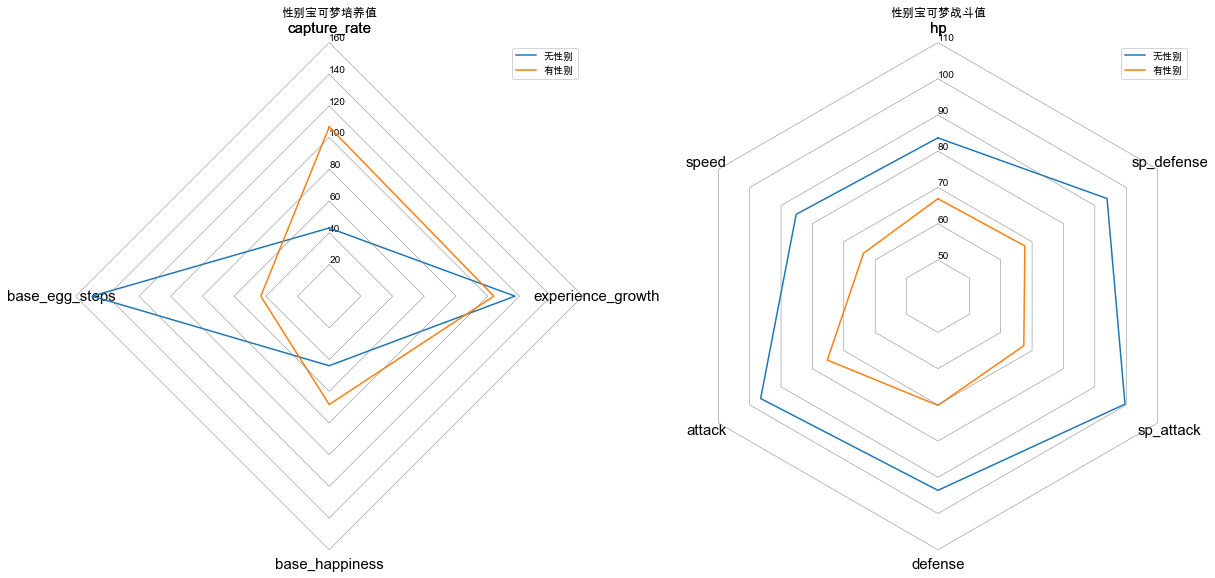

In [68]:
df1 = df[['percentage_male','capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth', 'hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].copy()
df1 = df1.fillna('无性别')
df1.loc[df1['percentage_male']!='无性别',['percentage_male']] = '有性别'
df1['base_egg_steps'] = df1['base_egg_steps']/df1['base_egg_steps'].max()*240
df1['experience_growth'] = df1['experience_growth']/10000

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(121, polar=True)
df11 = df1.groupby('percentage_male')[['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']].agg('mean')
radarplot(ax1, df11, rlim=[0, 160], step=20, title='性别宝可梦培养值')

ax2 = plt.subplot(122, polar=True)
df12 = df1.groupby('percentage_male')[['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].agg('mean')
radarplot(ax2, df12, rlim=[40, 110], step=10, title='性别宝可梦战斗值')

Text(0.5, 1.0, '性别宝可梦战斗值分布')

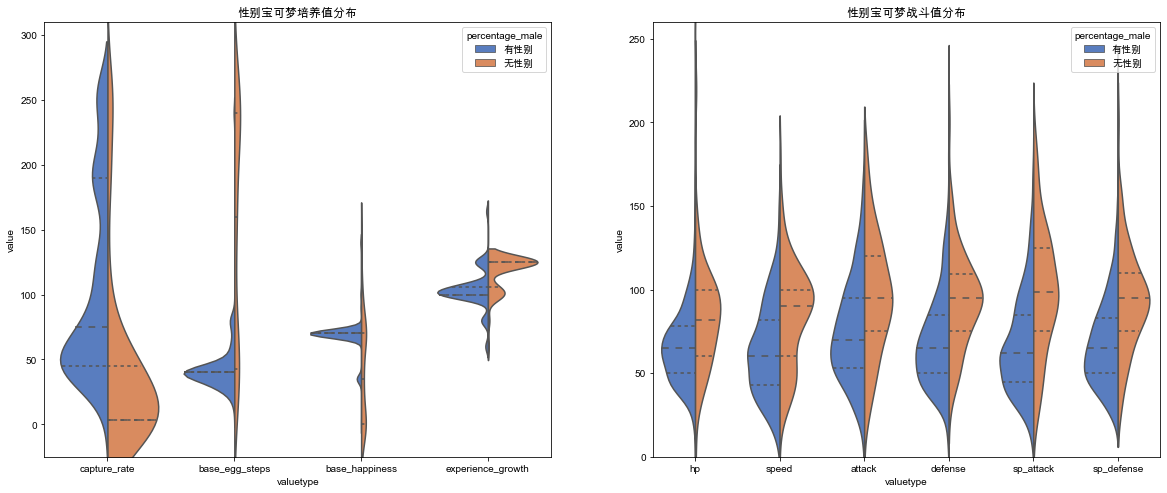

In [69]:
fig = plt.figure(figsize=(20,8))

fig.add_subplot(121)
df21=pd.DataFrame()
for feat in ['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']:
    t = df1[[feat,'percentage_male']].copy()
    t.columns = ['value', 'percentage_male']
    t['valuetype'] = feat
    df21 = pd.concat([df21, t], axis=0)
sns.violinplot(x='valuetype', y='value', hue='percentage_male', data=df21, palette="muted", split=True, inner="quartile")
plt.ylim(-25,310)
plt.title('性别宝可梦培养值分布')

fig.add_subplot(122)
df22=pd.DataFrame()
for feat in ['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']:
    t = df1[[feat,'percentage_male']].copy()
    t.columns = ['value', 'percentage_male']
    t['valuetype'] = feat
    df22 = pd.concat([df22, t], axis=0)
sns.violinplot(x='valuetype', y='value', hue='percentage_male', data=df22, palette="muted", split=True, inner="quartile")
plt.ylim(0,260)
plt.title('性别宝可梦战斗值分布')

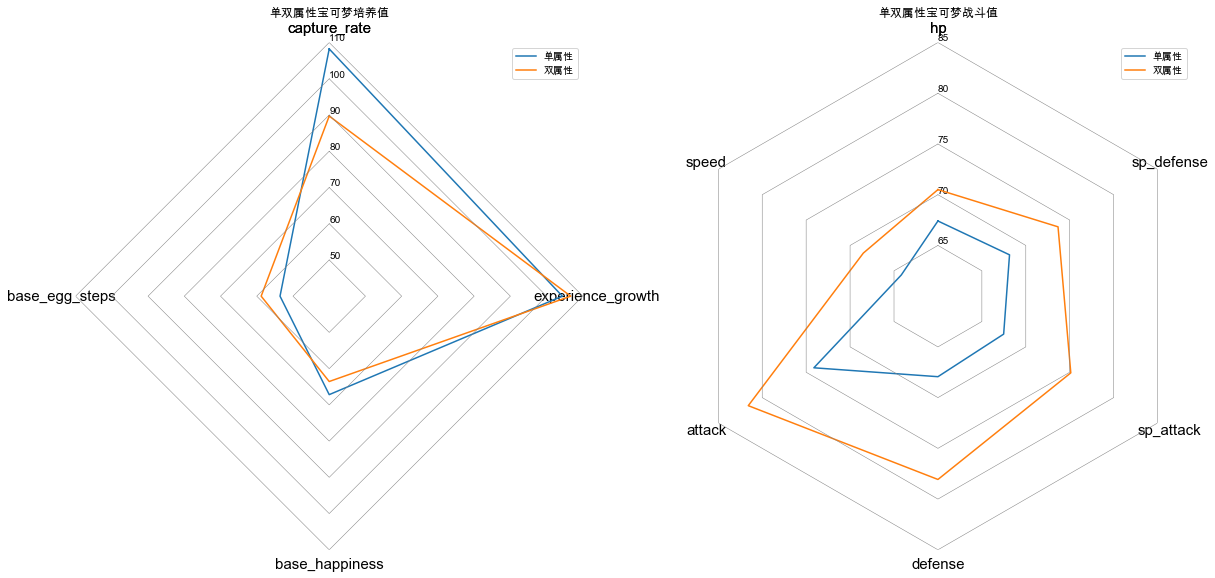

In [70]:
df1 = df[['double_type','capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth', 'hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].copy()
df1.loc[df1['double_type']==0,['double_type']] = '单属性'
df1.loc[df1['double_type']==1,['double_type']] = '双属性'
df1['base_egg_steps'] = df1['base_egg_steps']/df1['base_egg_steps'].max()*240
df1['experience_growth'] = df1['experience_growth']/10000

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(121, polar=True)
df11 = df1.groupby('double_type')[['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']].agg('mean')
radarplot(ax1, df11, rlim=[40, 110], step=10, title='单双属性宝可梦培养值')

ax2 = plt.subplot(122, polar=True)
df12 = df1.groupby('double_type')[['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].agg('mean')
radarplot(ax2, df12, rlim=[60, 85], step=5, title='单双属性宝可梦战斗值')

Text(0.5, 1.0, '单双属性宝可梦战斗值分布')

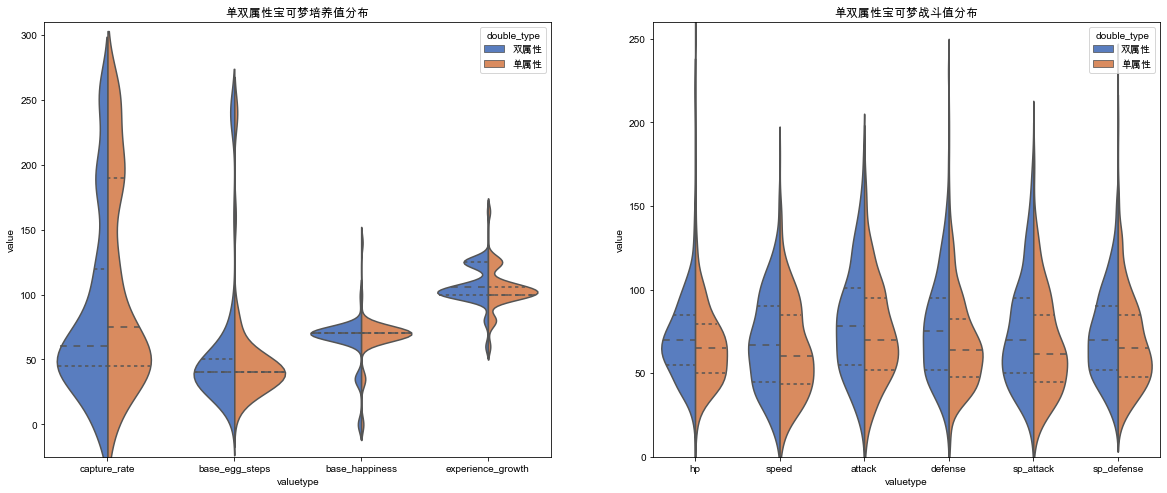

In [71]:
fig = plt.figure(figsize=(20,8))

fig.add_subplot(121)
df21=pd.DataFrame()
for feat in ['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']:
    t = df1[[feat,'double_type']].copy()
    t.columns = ['value', 'double_type']
    t['valuetype'] = feat
    df21 = pd.concat([df21, t], axis=0)
sns.violinplot(x='valuetype', y='value', hue='double_type', data=df21, palette="muted", split=True, inner="quartile")
plt.ylim(-25,310)
plt.title('单双属性宝可梦培养值分布')

fig.add_subplot(122)
df22=pd.DataFrame()
for feat in ['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']:
    t = df1[[feat,'double_type']].copy()
    t.columns = ['value', 'double_type']
    t['valuetype'] = feat
    df22 = pd.concat([df22, t], axis=0)
sns.violinplot(x='valuetype', y='value', hue='double_type', data=df22, palette="muted", split=True, inner="quartile")
plt.ylim(0,260)
plt.title('单双属性宝可梦战斗值分布')

## 3.6 传说的宝可梦

总数 70


<AxesSubplot:xlabel='generation'>

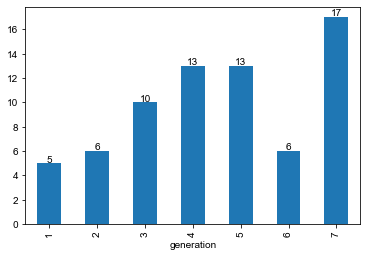

In [72]:
lgd = df[df['is_legendary']==1]
print('总数', len(lgd))
df1 = lgd.groupby('generation')['is_legendary'].agg('sum')
for x,y in enumerate(df1):
    plt.text(x,y+0.1,'%s' %y,ha='center')
df1.plot.bar()

属性组合种类 51


Text(0.5, 1.0, '单双属性宝可梦分布')

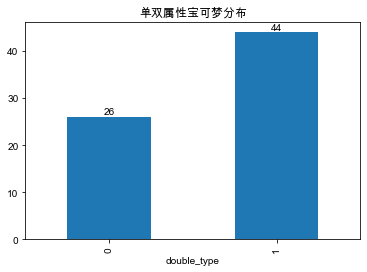

In [73]:
print('属性组合种类', len(lgd['typegroup'].unique()))
# 51种属性组合，不做更多研究，转而分析单个属性
# df1 = lgd.groupby('typegroup')['is_legendary'].agg('sum')
# df1.plot.bar()

df1 = lgd.groupby('double_type')['double_type'].count()
df1.plot.bar()
for x,y in enumerate(df1):
    plt.text(x,y+0.5,'%s' %y,ha='center')
plt.title('单双属性宝可梦分布')

In [74]:
df1=pd.DataFrame()
for type in types:
    lgd1 = lgd[typeis(lgd, type)]
    single = len(lgd1[lgd1['double_type']==0])
    double = len(lgd1[lgd1['double_type']==1])
    df1[type] = [single, double]

In [75]:
df1 = df1.T
df1.columns = ['单属性', '双属性']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'normal'),
  Text(1, 0, 'poison'),
  Text(2, 0, 'ground'),
  Text(3, 0, 'ice'),
  Text(4, 0, 'dark'),
  Text(5, 0, 'bug'),
  Text(6, 0, 'ghost'),
  Text(7, 0, 'rock'),
  Text(8, 0, 'water'),
  Text(9, 0, 'electric'),
  Text(10, 0, 'grass'),
  Text(11, 0, 'fire'),
  Text(12, 0, 'fighting'),
  Text(13, 0, 'fairy'),
  Text(14, 0, 'steel'),
  Text(15, 0, 'flying'),
  Text(16, 0, 'psychic'),
  Text(17, 0, 'dragon')])

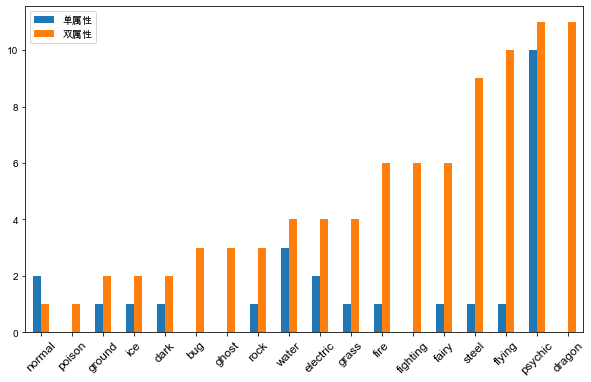

In [76]:
df1 = df1.sort_values(by='双属性')
df1.plot(kind='bar', figsize=(10,6))
plt.xticks(rotation=45, size=12)

Text(0.5, 1.0, '传说/非传说宝可梦身高分布')

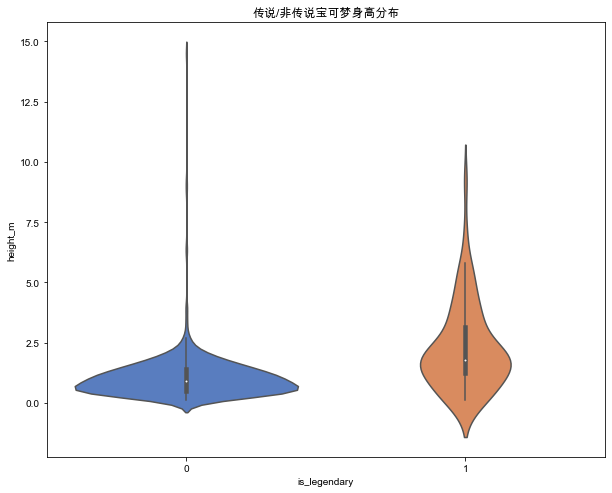

In [77]:
plt.figure(figsize=(10,8))
sns.violinplot(x='is_legendary', y='height_m', data=df, palette="muted", split=True)
plt.title('传说/非传说宝可梦身高分布')

Text(0.5, 1.0, '传说/非传说宝可梦体重分布')

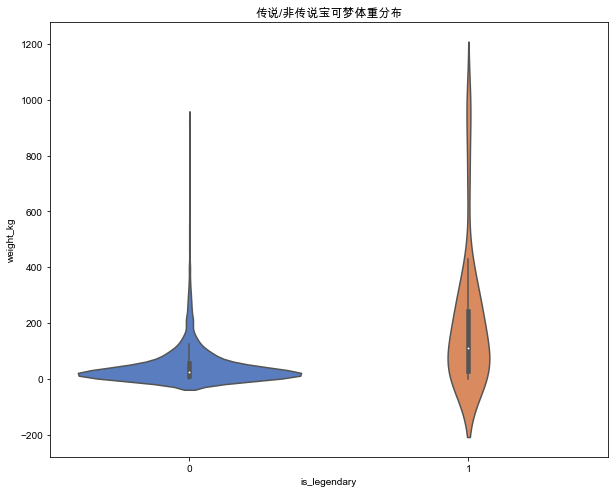

In [78]:
plt.figure(figsize=(10,8))
sns.violinplot(x='is_legendary', y='weight_kg', data=df, palette="muted", split=True)
plt.title('传说/非传说宝可梦体重分布')

Text(0.5, 1.0, '传说/非传说宝可梦BMI分布')

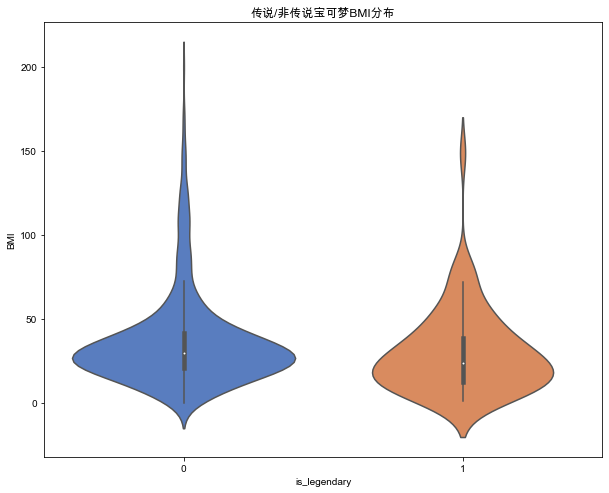

In [79]:
plt.figure(figsize=(10,8))
sns.violinplot(x='is_legendary', y='BMI', data=df[df['BMI']<=200], palette="muted", split=True)
plt.title('传说/非传说宝可梦BMI分布')

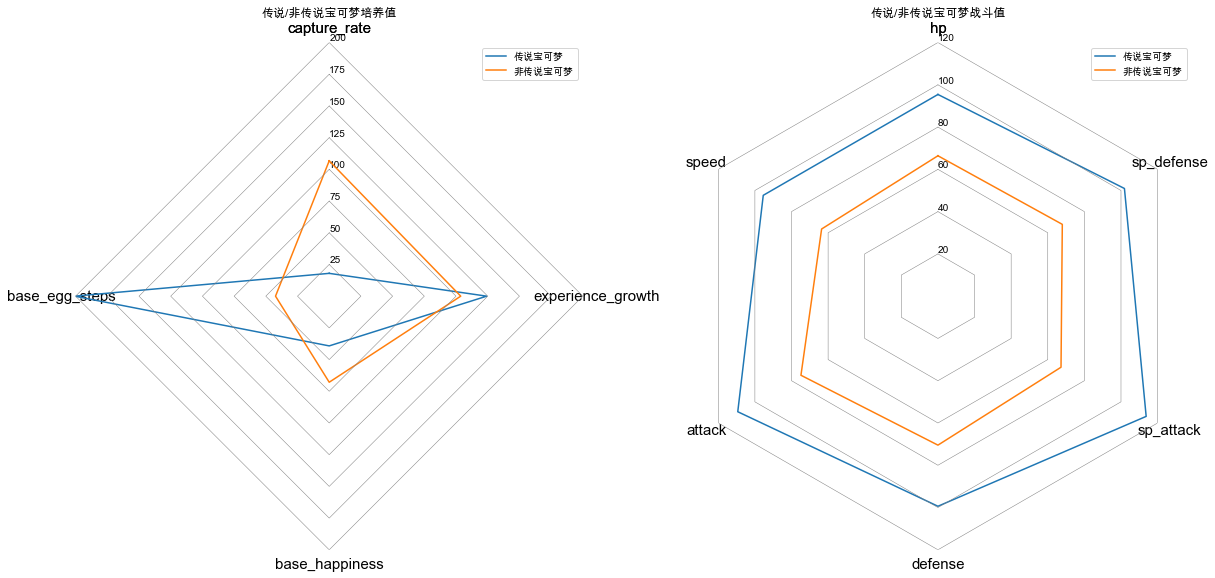

In [80]:
df1 = df[['is_legendary','capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth', 'hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].copy()
df1.loc[df1['is_legendary']==1,['is_legendary']] = '传说宝可梦'
df1.loc[df1['is_legendary']==0,['is_legendary']] = '非传说宝可梦'
df1['base_egg_steps'] = df1['base_egg_steps']/df1['base_egg_steps'].max()*240
df1['experience_growth'] = df1['experience_growth']/10000

fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot(121, polar=True)
df11 = df1.groupby('is_legendary')[['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']].agg('mean')
radarplot(ax1, df11, rlim=[0, 200], step=25, title='传说/非传说宝可梦培养值')

ax2 = plt.subplot(122, polar=True)
df12 = df1.groupby('is_legendary')[['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']].agg('mean')
radarplot(ax2, df12, rlim=[0, 120], step=20, title='传说/非传说宝可梦战斗值')

Text(0.5, 1.0, '传说/非传说宝可梦战斗值分布')

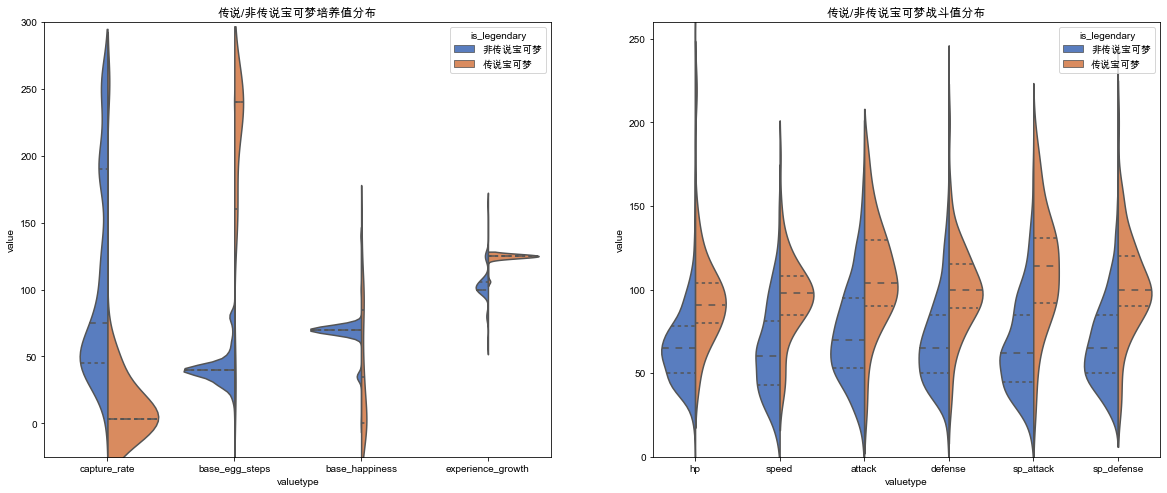

In [81]:
fig = plt.figure(figsize=(20,8))

fig.add_subplot(121)
df21=pd.DataFrame()
for feat in ['capture_rate', 'base_egg_steps', 'base_happiness', 'experience_growth']:
    t = df1[[feat,'is_legendary']].copy()
    t.columns = ['value', 'is_legendary']
    t['valuetype'] = feat
    df21 = pd.concat([df21, t], axis=0)
sns.violinplot(x='valuetype', y='value', hue='is_legendary', data=df21, palette="muted", split=True, inner="quartile")
plt.ylim(-25,300)
plt.title('传说/非传说宝可梦培养值分布')

fig.add_subplot(122)
df22=pd.DataFrame()
for feat in ['hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense']:
    t = df1[[feat,'is_legendary']].copy()
    t.columns = ['value', 'is_legendary']
    t['valuetype'] = feat
    df22 = pd.concat([df22, t], axis=0)
sns.violinplot(x='valuetype', y='value', hue='is_legendary', data=df22, palette="muted", split=True, inner="quartile")
plt.ylim(0,260)
plt.title('传说/非传说宝可梦战斗值分布')

In [82]:
def corrHeat(Data, ax):
    plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
    # sns.set_style('whitegrid',{'font.sans-serif':['Arial Unicode MS','Arial']})

    corr = Data.corr()
    plt.figure(figsize=(15,12))
    g = sns.heatmap(corr, vmax=0.9, cmap="YlGnBu", square=True, ax = ax)
    # plt.show()
    return g

# corrHeat(df.drop(790), [])

# 4 回归
逻辑回归  
决策树  
TenserFlow
### 注意样本的非平衡性

In [83]:
# min-max标准化
def mNormalization(series):
    return (series - np.min(series)) / (np.max(series) - np.min(series))
# Z-score标准化
def zNormalization(series):
    return (series - np.mean(series)) / np.std(series)
# 对数缩放
def logNormalization(series):
    return np.log(series+1)

<AxesSubplot:ylabel='Frequency'>

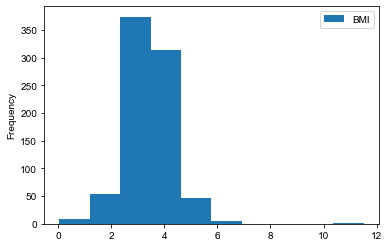

In [84]:
t = df[['BMI']].apply(logNormalization)
# 对数缩放比正态缩放更有效
# t = pokemon_set[['BMI']].apply(zNormalization)
t.plot.hist()

In [85]:
# 数据重整
# 将type1和type2聚合独热编码
pokemon_set = df.copy()
for type in types:
    pokemon_set.loc[typeis(pokemon_set, type),'is_'+type] = 1

# 将性别特征重编码
pokemon_set.loc[pokemon_set['percentage_male'].isnull(),['is_nogender']] = 1
pokemon_set.loc[pokemon_set['percentage_male']==50.,['is_blcgender']] = 1
pokemon_set.loc[pokemon_set['percentage_male']<50.,['is_fmgender']] = 1
pokemon_set.loc[pokemon_set['percentage_male']>50.,['is_mlgender']] = 1

# 初步缩放部分特征
pokemon_set['base_egg_steps'] = pokemon_set['base_egg_steps']/pokemon_set['base_egg_steps'].max()*240
pokemon_set['experience_growth'] = pokemon_set['experience_growth']/10000
pokemon_set['height_m'] = pokemon_set[['height_m']].apply(logNormalization)
pokemon_set['weight_kg'] = pokemon_set[['weight_kg']].apply(logNormalization)
pokemon_set['BMI'] = pokemon_set[['BMI']].apply(logNormalization)

# 删除部分特征
pokemon_set = pokemon_set.drop(columns=['percentage_male','japanese_name','name','type1','type2','typegroup'])
pokemon_set = pokemon_set.fillna(0)
describe(pokemon_set, pokemon_set.columns.tolist())

,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,attack,801,77.857678,5,75.000000,185,32.158820
1,base_egg_steps,801,56.179775,10.0,40.000000,240.0,51.236097
2,base_happiness,801,65.362047,0,70.000000,140,19.598948
3,base_total,801,428.377029,180,435.000000,780,119.203577
4,capture_rate,801,98.956305,3,60.000000,255,76.409828
5,defense,801,73.008739,5,70.000000,230,30.769159
6,experience_growth,801,105.499591,60.0,100.000000,164.0,16.025584
7,height_m,801,0.697232,0.09531,0.693147,2.74084,0.344812
8,hp,801,68.958801,1,65.000000,255,26.576015
9,sp_attack,801,71.305868,10,65.000000,194,32.353826


## 4.1 逻辑回归
在封装的回归函数中加入class_weight='balanced'  
并计算对数损失函数

In [86]:
def VarClassification(dataframe: pd.DataFrame, depVar: str, indVarList: list, testsize: float=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(dataframe[indVarList], dataframe[[depVar]], test_size=testsize)
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train, Y_train.values.ravel())
    Y_predict_value = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
    Y_predict_label = model.predict(X_test)  # 各个测试样本预测出的标签

    print("分类任务：%s\n变量(%d)：%s\n" %(depVar, len(indVarList), indVarList))
    print('Log Loss (balanced):', log_loss(Y_test, Y_predict_value))

    fig4 = plt.figure(figsize=(12, 6), facecolor='w')
    plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

    # Plot confusion matrix
    confusion = confusion_matrix(Y_test, Y_predict_label)
    # print(confusion)
    ax1 = fig4.add_subplot(1,2,1)
    # Generate ticks
    classes = list(set(dataframe[depVar]))
    classes.sort()

    plt.title('Test Set Confusion Matrix')
    plt.imshow(confusion, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(confusion)), classes)
    plt.yticks(range(len(confusion)), classes)
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    for y_index in range(len(confusion)):
        for x_index in range(len(confusion[y_index])):
            plt.text(x_index, y_index, confusion[y_index][x_index])

    # Plot ROC curve
    ax2 = fig4.add_subplot(1,2,2)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_value)
    roc_auc = auc(fpr, tpr)
    plt.title('AUC:%.3f, f1 score:%.3f' %(roc_auc, f1_score(Y_test, Y_predict_label)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)

    fig4.tight_layout()
    plt.show()

In [87]:
indlist = pokemon_set.columns.to_list()
indlist.remove('is_legendary')

### 4.1.1 单变量
在小提琴图中注意到'base_egg_steps'的差异明显 

分类任务：is_legendary
变量(1)：['base_egg_steps']

Log Loss (balanced): 0.14174121319959418


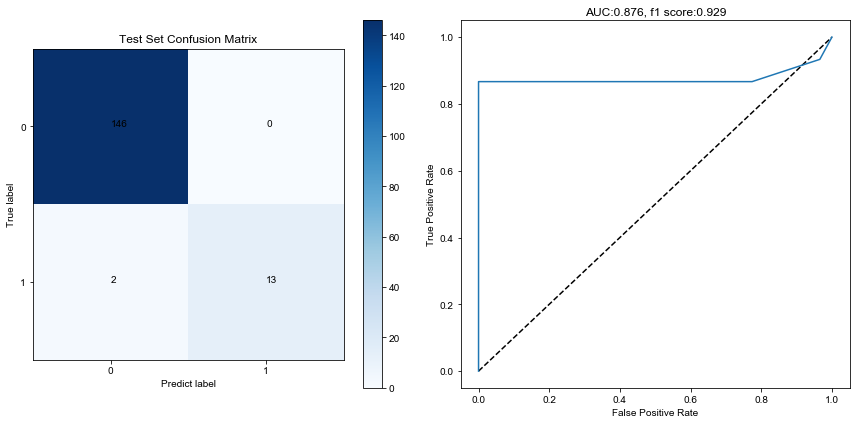

In [88]:
VarClassification(pokemon_set, 'is_legendary', ['base_egg_steps'])

### 4.1.2 多元逻辑回归

分类任务：is_legendary
变量(38)：['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'generation', 'double_type', 'BMI', 'is_fire', 'is_water', 'is_bug', 'is_normal', 'is_poison', 'is_electric', 'is_ground', 'is_fairy', 'is_fighting', 'is_psychic', 'is_grass', 'is_dragon', 'is_rock', 'is_dark', 'is_ghost', 'is_ice', 'is_steel', 'is_flying', 'is_nogender', 'is_blcgender', 'is_fmgender', 'is_mlgender']

Log Loss (balanced): 0.15068278183175682


/Users/bryan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


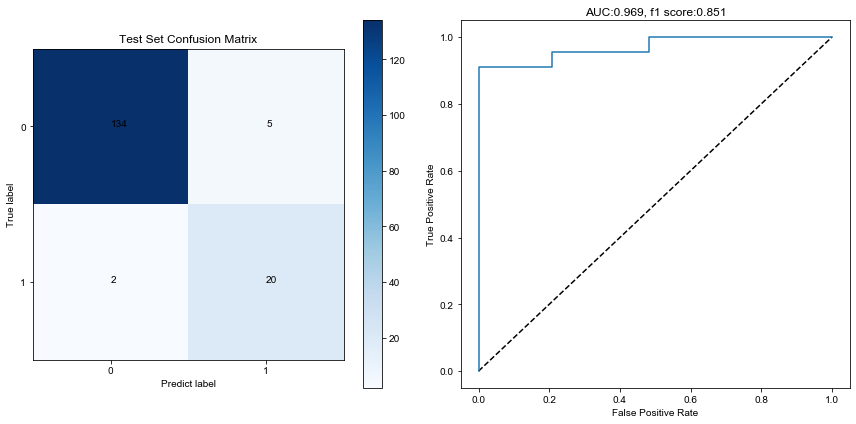

In [89]:
VarClassification(pokemon_set, 'is_legendary', indlist)

### 4.1.3 K折交叉验证

In [90]:
def PltFigure(type, Y_test, Y_predict_label, Y_predict_value, score, fig, imgidx):
    if type=='confusion':
        # Plot confusion matrix
        confusion = confusion_matrix(Y_test, Y_predict_label)
        # print(confusion) # 检查点
        fig.add_subplot(2,3,imgidx+1)
        # Generate ticks
        classes = list(set(Y_test['标签']))
        classes.sort()

        plt.title('Test Set Confusion Matrix')
        plt.imshow(confusion, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xticks(range(len(confusion)), classes)
        plt.yticks(range(len(confusion)), classes)
        plt.xlabel('Predict label')
        plt.ylabel('True label')
        for y_index in range(len(confusion)):
            for x_index in range(len(confusion[y_index])):
                plt.text(x_index, y_index, confusion[y_index][x_index])
    elif type=='roc':
        # Plot ROC curve
        fig.add_subplot(2,3,imgidx+1)
        fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_value)
        roc_auc = auc(fpr, tpr)
        plt.title('AUC:%.3f, f1 score:%.3f' %(roc_auc, score))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)

In [91]:
# 设计函数，接受x,y,k折次数n和c_param列表，转置参数, 输出一个dataframe
def find_best_C(xset, yset, k: int=5, C_list: list=[0.001, 0.01, 0.1, 1, 10, 100], transpose: bool=False, max_it: int=100):
    kf = KFold(k, shuffle=True)
    result_list = [] # 储存不同C参数的得分条
    for c in C_list:
        c_result_score = [] # 储存一个C参数下k折交叉验证的得分

        # fig4 = plt.figure(figsize=(12, 8), facecolor='w')
        # plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
        # plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

        for img, (train, test) in enumerate(kf.split(xset, yset)):
            model = LogisticRegression(C=c, penalty='l2', max_iter=max_it)
            # model = LogisticRegression(C=c, penalty='l2')
            model.fit(xset.iloc[train], yset.iloc[train].values.ravel())
            Y_predict_label = model.predict(xset.iloc[test])
            score = f1_score(yset.iloc[test], Y_predict_label)
            # display(yset.iloc[test].head())
            c_result_score.append(score)

        #     Y_predict_value = model.predict_proba(xset.iloc[test])[:, 1]  # 各个测试样本 softmax ，用于计算 roc
        #     PltFigure('roc', yset.iloc[test], Y_predict_label, Y_predict_value, score, fig4, img)
        # plt.tight_layout()
        # plt.show()

        result_list.append([np.mean(c_result_score)]+c_result_score+[str(c)])

    result_list = pd.DataFrame(result_list) # 转换成DataFrame
    result_list.rename(columns={0:'Mean Score', k+1:'C Parameter'}, inplace=True) # 重命名平均值和参数列
    result_list.set_index('C Parameter', inplace=True)
    # result_list.style.background_gradient(subset=['Mean Score'])

    if not transpose:
        display(result_list.style.highlight_max(color='orange',subset=['Mean Score']))
    else:
        display(result_list.T.head(1).style.highlight_max(color='orange', axis=1))
        display(result_list.T.drop(index=['Mean Score']))

    best_score = result_list['Mean Score'].max()
    best_c = result_list[(result_list['Mean Score']==best_score)].index.tolist()
    for best in best_c:
        print('Best C Parameter: %s' %best)

In [92]:
find_best_C(
    xset= pokemon_set[indlist], 
    yset= pokemon_set[['is_legendary']],
    # k= 5,
    # C_list= [0.001, 0.01, 0.1, 1, 10, 100],
    max_it=500)

/Users/bryan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bryan/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

,Mean Score,1,2,3,4,5
C Parameter,,,,,,
0.001,0.890622,0.937500,0.952381,0.937500,0.888889,0.736842
0.01,0.879511,0.916667,0.814815,0.800000,0.937500,0.928571
0.1,0.903230,0.952381,0.960000,0.818182,0.866667,0.918919
1,0.914683,0.871795,0.960000,0.962963,0.909091,0.869565
10,0.904318,0.814815,0.923077,0.909091,0.965517,0.909091
100,0.878649,0.952381,0.842105,0.937500,0.764706,0.896552


Best C Parameter: 1


## 4.2 树和集成学习

In [93]:
def Classification(modelname: str, dataframe: pd.DataFrame, depVar: str, indVarList: list, testsize: float=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(dataframe[indVarList], dataframe[[depVar]], test_size=testsize)
    # model = LogisticRegression(class_weight='balanced')
    if modelname=='DecisionTree':
        model = DecisionTreeClassifier()
    elif modelname=='RandomForest':
        model = RandomForestClassifier()
    elif modelname=='GradientBoosting' or modelname=='GDBT':
        model = GradientBoostingClassifier()
    elif modelname=='XGB':
        model = XGBClassifier()
    elif modelname=='LightGBM' or modelname=='LGBM':
        model = LGBMClassifier()

    model.fit(X_train, Y_train.values.ravel())
    Y_predict_value = model.predict(X_test)
    features = X_train.columns
    importances = model.feature_importances_

    print(modelname)
    print("分类任务：%s\n变量(%d)：%s\n" %(depVar, len(indVarList), indVarList))
    print('Log Loss:', log_loss(Y_test, Y_predict_value))
    print(classification_report(Y_predict_value,Y_test))
    
    t = pd.DataFrame([features, importances], index=['Features','Importances'])
    t = t.T
    t = t.sort_values(by='Importances', ascending=False)
    t.index = range(1, len(t)+1)
    display(t[t['Importances']!=0.0])

    fig4 = plt.figure(figsize=(12, 6), facecolor='w')
    plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

        # Plot confusion matrix
    confusion = confusion_matrix(Y_test, Y_predict_value)
    # print(confusion)
    ax1 = fig4.add_subplot(1,2,1)
    # Generate ticks
    classes = list(set(dataframe[depVar]))
    classes.sort()

    plt.title(modelname+'\nTest Set Confusion Matrix')
    plt.imshow(confusion, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(confusion)), classes)
    plt.yticks(range(len(confusion)), classes)
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    for y_index in range(len(confusion)):
        for x_index in range(len(confusion[y_index])):
            plt.text(x_index, y_index, confusion[y_index][x_index])

    # Plot ROC curve
    ax2 = fig4.add_subplot(1,2,2)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_value)
    roc_auc = auc(fpr, tpr)
    plt.title('AUC:%.3f, f1 score:%.3f' %(roc_auc, f1_score(Y_test, Y_predict_value)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)

    fig4.tight_layout()
    plt.show()

    if modelname=='DecisionTree':
        dot_data = tree.export_graphviz(model, out_file=None,
                    feature_names=indVarList,
                    class_names=['普通宝可梦','传说的宝可梦'],
                    filled=True, rounded=True,
                    special_characters=True)
        graph = graphviz.Source(dot_data)
        display(graph)

DecisionTree
分类任务：is_legendary
变量(38)：['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'generation', 'double_type', 'BMI', 'is_fire', 'is_water', 'is_bug', 'is_normal', 'is_poison', 'is_electric', 'is_ground', 'is_fairy', 'is_fighting', 'is_psychic', 'is_grass', 'is_dragon', 'is_rock', 'is_dark', 'is_ghost', 'is_ice', 'is_steel', 'is_flying', 'is_nogender', 'is_blcgender', 'is_fmgender', 'is_mlgender']

Log Loss: 9.992007221626413e-16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       146
           1       1.00      1.00      1.00        15

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



,Features,Importances
1,base_egg_steps,0.916795
2,capture_rate,0.044923
3,base_total,0.019891
4,is_normal,0.01839


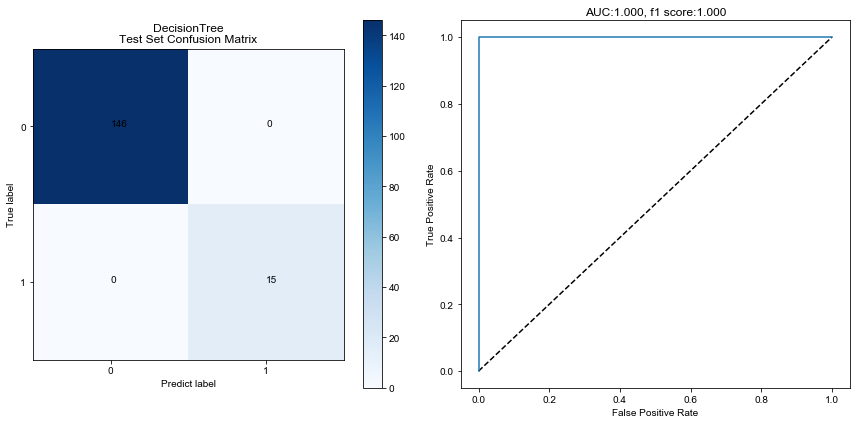

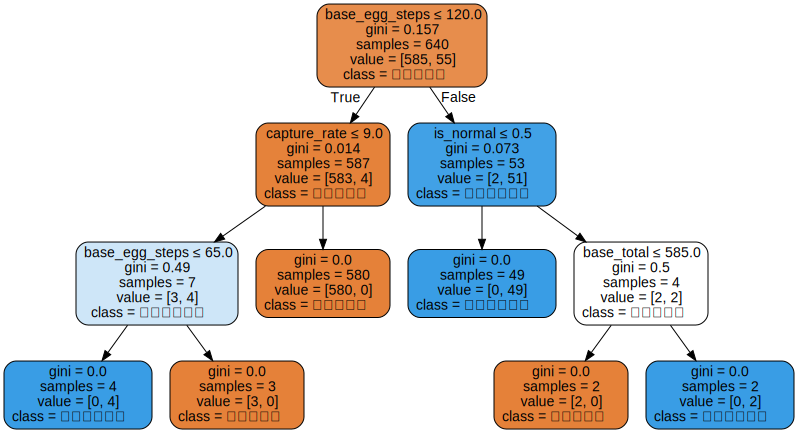

RandomForest
分类任务：is_legendary
变量(38)：['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'generation', 'double_type', 'BMI', 'is_fire', 'is_water', 'is_bug', 'is_normal', 'is_poison', 'is_electric', 'is_ground', 'is_fairy', 'is_fighting', 'is_psychic', 'is_grass', 'is_dragon', 'is_rock', 'is_dark', 'is_ghost', 'is_ice', 'is_steel', 'is_flying', 'is_nogender', 'is_blcgender', 'is_fmgender', 'is_mlgender']

Log Loss: 9.992007221626413e-16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00        11

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



,Features,Importances
1,base_egg_steps,0.233165
2,capture_rate,0.150963
3,base_total,0.148464
4,is_nogender,0.0904
5,base_happiness,0.081085
6,experience_growth,0.050125
7,height_m,0.033254
8,weight_kg,0.029793
9,is_blcgender,0.027165
10,sp_attack,0.022803


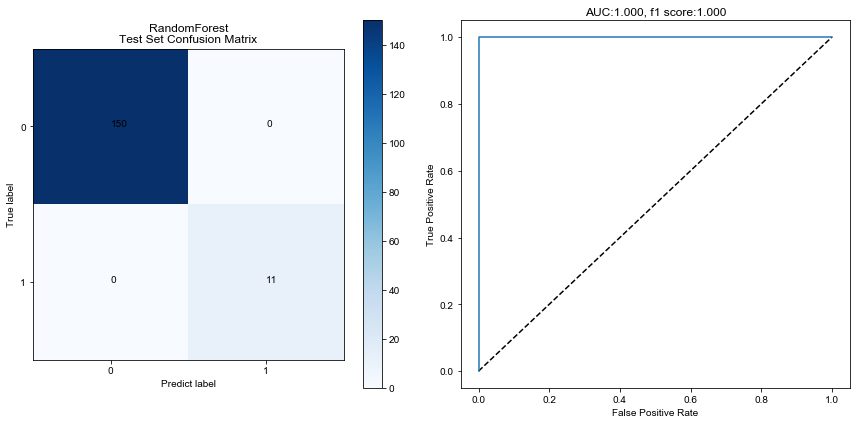

GDBT
分类任务：is_legendary
变量(38)：['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'generation', 'double_type', 'BMI', 'is_fire', 'is_water', 'is_bug', 'is_normal', 'is_poison', 'is_electric', 'is_ground', 'is_fairy', 'is_fighting', 'is_psychic', 'is_grass', 'is_dragon', 'is_rock', 'is_dark', 'is_ghost', 'is_ice', 'is_steel', 'is_flying', 'is_nogender', 'is_blcgender', 'is_fmgender', 'is_mlgender']

Log Loss: 0.2145315279027393
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       146
           1       1.00      0.93      0.97        15

    accuracy                           0.99       161
   macro avg       1.00      0.97      0.98       161
weighted avg       0.99      0.99      0.99       161



,Features,Importances
1,base_egg_steps,0.913981
2,capture_rate,0.051696
3,base_happiness,0.011138
4,base_total,0.009949
5,is_psychic,0.005655
6,height_m,0.002819
7,generation,0.00199
8,BMI,0.001094
9,sp_defense,0.000948
10,sp_attack,0.000332


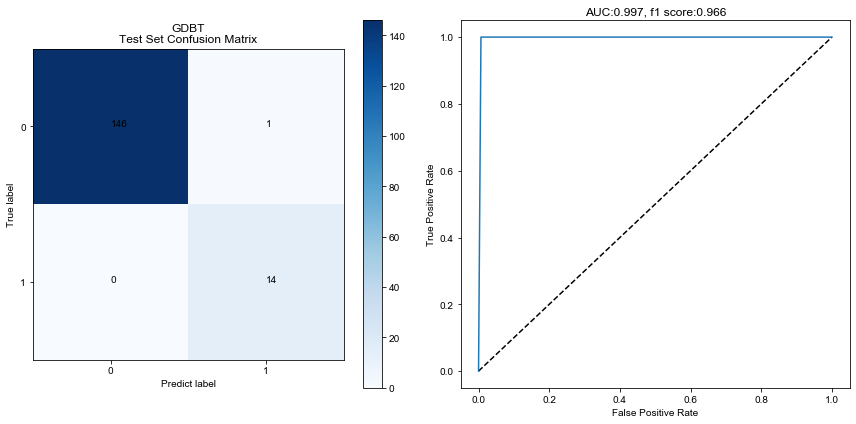

[23:22:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
分类任务：is_legendary
变量(38)：['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'generation', 'double_type', 'BMI', 'is_fire', 'is_water', 'is_bug', 'is_normal', 'is_poison', 'is_electric', 'is_ground', 'is_fairy', 'is_fighting', 'is_psychic', 'is_grass', 'is_dragon', 'is_rock', 'is_dark', 'is_ghost', 'is_ice', 'is_steel', 'is_flying', 'is_nogender', 'is_blcgender', 'is_fmgender', 'is_mlgender']

Log Loss: 0.2145265614590735
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       157
           1       0

/Users/bryan/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Features,Importances
1,base_egg_steps,0.51347
2,capture_rate,0.145427
3,base_total,0.130929
4,is_nogender,0.073467
5,is_normal,0.04892
6,hp,0.025889
7,sp_attack,0.015484
8,generation,0.013878
9,weight_kg,0.007112
10,sp_defense,0.006272


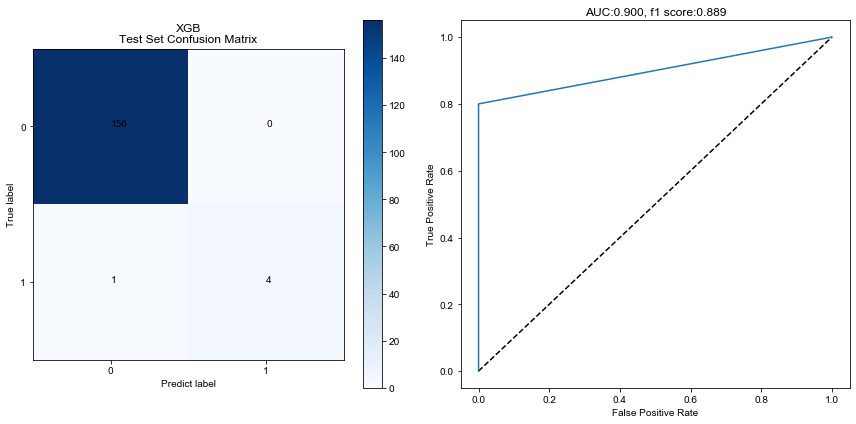

LGBM
分类任务：is_legendary
变量(38)：['attack', 'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate', 'defense', 'experience_growth', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'generation', 'double_type', 'BMI', 'is_fire', 'is_water', 'is_bug', 'is_normal', 'is_poison', 'is_electric', 'is_ground', 'is_fairy', 'is_fighting', 'is_psychic', 'is_grass', 'is_dragon', 'is_rock', 'is_dark', 'is_ghost', 'is_ice', 'is_steel', 'is_flying', 'is_nogender', 'is_blcgender', 'is_fmgender', 'is_mlgender']

Log Loss: 0.429053122918146
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       152
           1       0.82      1.00      0.90         9

    accuracy                           0.99       161
   macro avg       0.91      0.99      0.95       161
weighted avg       0.99      0.99      0.99       161



,Features,Importances
1,base_total,349
2,capture_rate,215
3,weight_kg,198
4,sp_attack,193
5,base_egg_steps,183
6,attack,159
7,BMI,146
8,defense,140
9,height_m,123
10,is_nogender,114


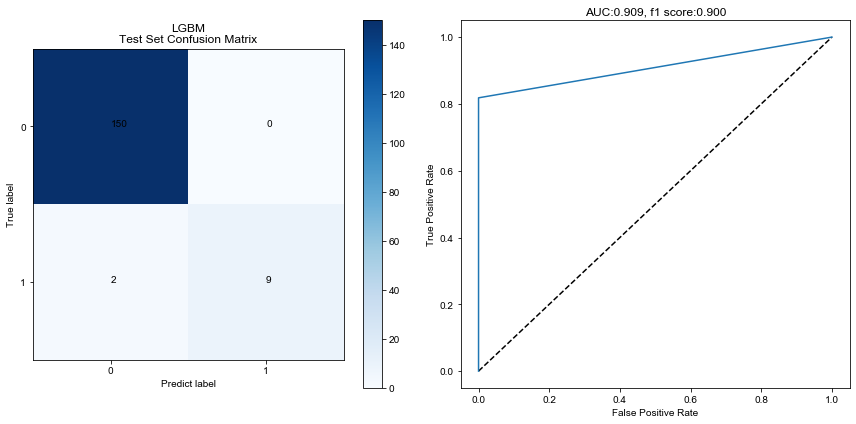

In [94]:
Classification('DecisionTree',pokemon_set, 'is_legendary', indlist)
Classification('RandomForest',pokemon_set, 'is_legendary', indlist)
Classification('GDBT',pokemon_set, 'is_legendary', indlist)
Classification('XGB',pokemon_set, 'is_legendary', indlist)
Classification('LGBM',pokemon_set, 'is_legendary', indlist)

DecisionTree
分类任务：is_legendary
变量(3)：['base_egg_steps', 'double_type', 'is_nogender']

Log Loss: 0.21452656145907353
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       0.92      1.00      0.96        11

    accuracy                           0.99       161
   macro avg       0.96      1.00      0.98       161
weighted avg       0.99      0.99      0.99       161



,Features,Importances
1,base_egg_steps,0.979147
2,is_nogender,0.017842
3,double_type,0.003011


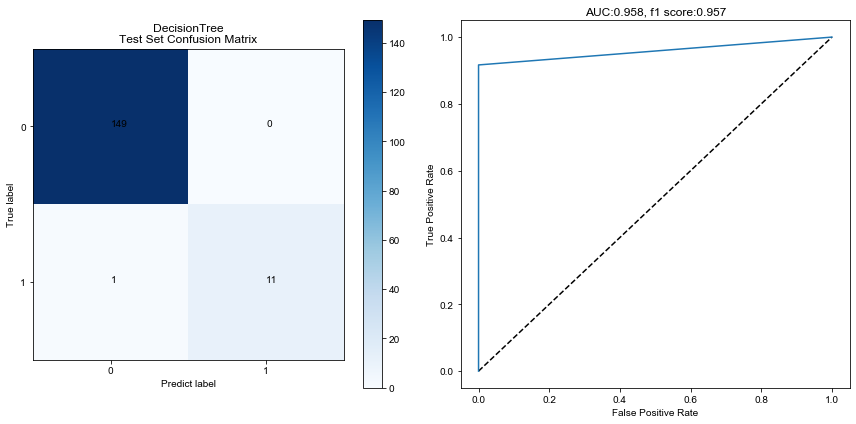

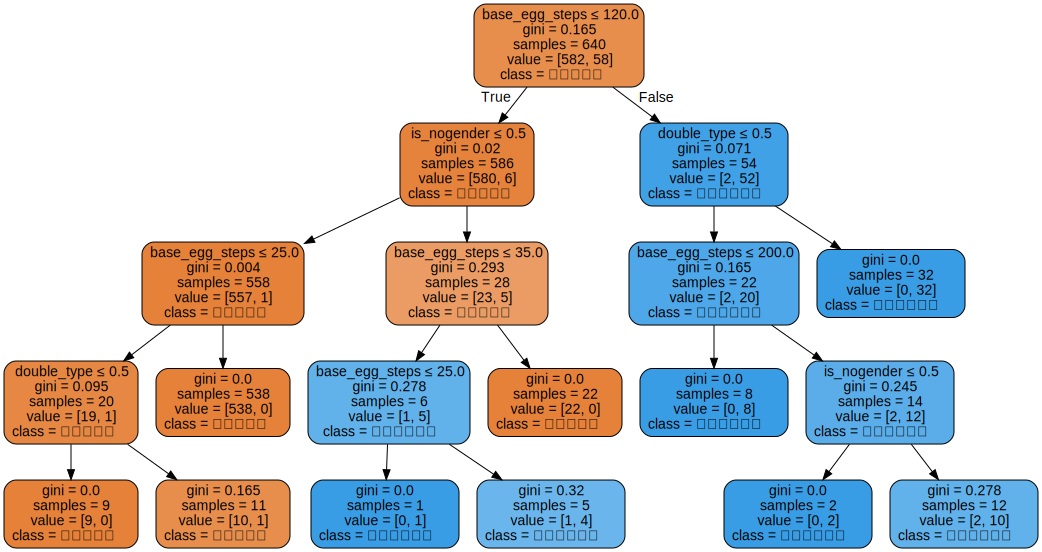

RandomForest
分类任务：is_legendary
变量(3)：['base_egg_steps', 'double_type', 'is_nogender']

Log Loss: 9.992007221626413e-16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00        16

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



,Features,Importances
1,base_egg_steps,0.656397
2,is_nogender,0.336364
3,double_type,0.007239


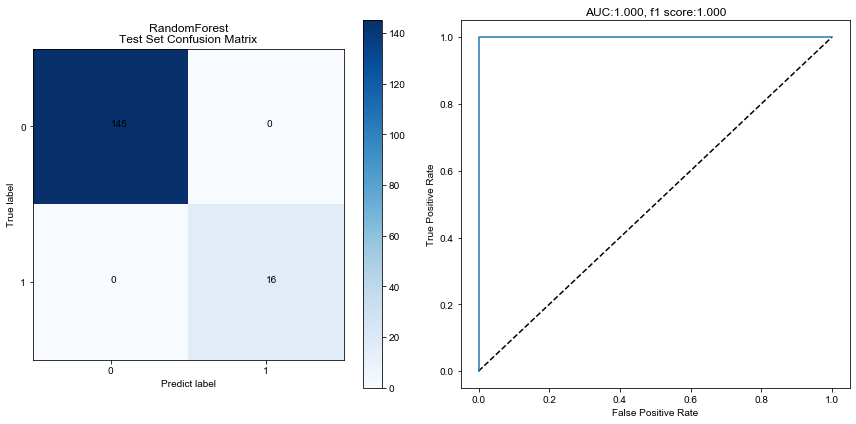

GDBT
分类任务：is_legendary
变量(3)：['base_egg_steps', 'double_type', 'is_nogender']

Log Loss: 9.992007221626413e-16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00        16

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



,Features,Importances
1,base_egg_steps,0.976704
2,is_nogender,0.018295
3,double_type,0.005


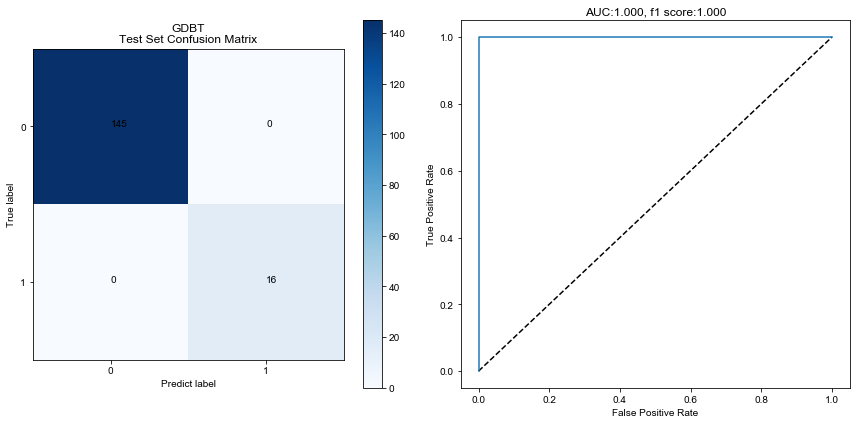

[23:22:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
分类任务：is_legendary
变量(3)：['base_egg_steps', 'double_type', 'is_nogender']

Log Loss: 0.4290580893618119
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.91      0.91      0.91        11

    accuracy                           0.99       161
   macro avg       0.95      0.95      0.95       161
weighted avg       0.99      0.99      0.99       161



/Users/bryan/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Features,Importances
1,base_egg_steps,0.919629
2,is_nogender,0.064017
3,double_type,0.016355


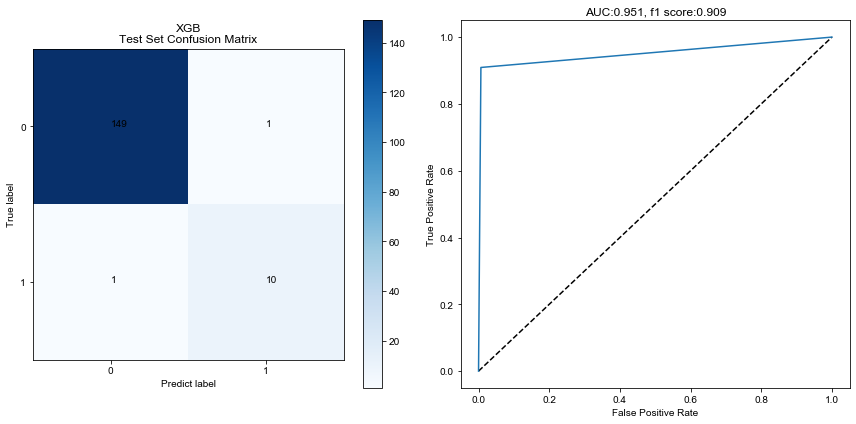

LGBM
分类任务：is_legendary
变量(3)：['base_egg_steps', 'double_type', 'is_nogender']

Log Loss: 9.992007221626413e-16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       143
           1       1.00      1.00      1.00        18

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



,Features,Importances
1,base_egg_steps,519
2,is_nogender,137
3,double_type,128


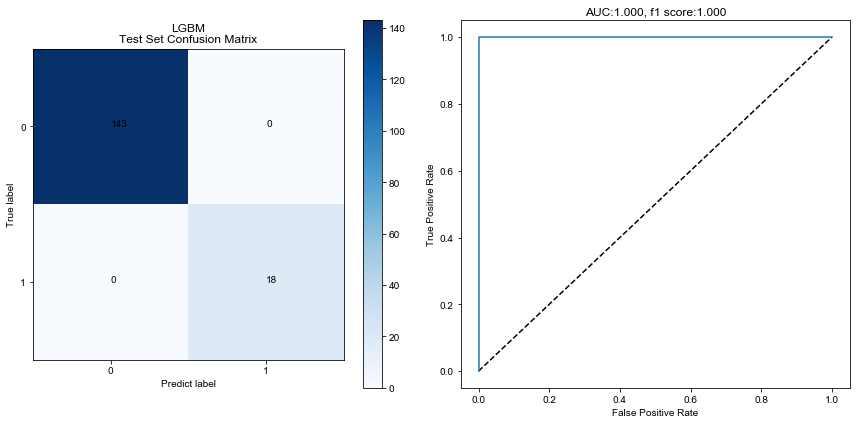

In [95]:
indlist = ['base_egg_steps','double_type','is_nogender']
Classification('DecisionTree',pokemon_set, 'is_legendary', indlist)
Classification('RandomForest',pokemon_set, 'is_legendary', indlist)
Classification('GDBT',pokemon_set, 'is_legendary', indlist)
Classification('XGB',pokemon_set, 'is_legendary', indlist)
Classification('LGBM',pokemon_set, 'is_legendary', indlist)

## 4.3 TensorFlow
### 若要运行以下代码，请将enable_tensorflow设为True
需要tensorflow、keras_metrics及依赖项。

In [96]:
enable_tensorflow = False
if enable_tensorflow:
    import tensorflow as tf
    from tensorflow import keras
    import keras_metrics as km
    # 在metrics中计算f1 score

    print('Pandas',pd.__version__)
    print('NumPy',np.__version__)
    print('TensorFlow',tf.__version__)
    print('keras_metrics', km.__version__)

In [97]:
# 打点回调函数
if enable_tensorflow:
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs):
            if epoch%100==0:
                print('\n',epoch,end='')
            print('.',end='')

In [98]:
def TFClassification(dataframe: pd.DataFrame, depVar: str, indVarList: list, testsize: float=0.2):
# 这里再次使用min-max标准化
    XY = dataframe[indVarList].apply(mNormalization)
    XY[[depVar]] = dataframe[[depVar]]
    describe(XY, XY.columns)
# 建模
    complexmodel = False # 使用多层神经网络
    if complexmodel:
        clfmodel = keras.Sequential([
            keras.layers.Dense(32,activation='relu',input_shape=(len(indVarList),)),
            # keras.layers.Dense(32,activation='relu'),
            keras.layers.Dense(2,activation='softmax')
        ])
    else:
        clfmodel = keras.Sequential([
            keras.layers.Dense(2,activation='softmax',input_shape=(len(indVarList),))
        ])

    clfmodel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy',km.f1_score()])
    clfmodel.summary()
# 数据变形
    data = x = tf.cast(XY[indVarList], dtype=tf.float32)
    labels = tf.squeeze(XY[depVar])
    labels = tf.one_hot(labels, depth=2)
# 拟合
    clfhistory = clfmodel.fit(data, labels, validation_split=testsize, epochs=6, verbose=0, callbacks=[PrintDot()])
    print(clfhistory.history.keys())
# 绘图
    def plot_clfhistory(history):
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(history.epoch,np.array(history.history['accuracy']),label='Train Accuracy')
        plt.plot(history.epoch,np.array(history.history['val_accuracy']),label='Validation Accuracy')
        plt.plot(history.epoch,np.array(history.history['f1_score']),label='Train f1')
        plt.plot(history.epoch,np.array(history.history['val_f1_score']),label='Validation f1')
        plt.legend()
        plt.show()

    plot_clfhistory(clfhistory)

In [99]:
if enable_tensorflow:
    # 减少变量数
    indlist = pokemon_set.columns.to_list()
    indlist.remove('is_legendary')
    TFClassification(pokemon_set, 'is_legendary', indlist)

    indlist = ['base_egg_steps', 'base_total', 'capture_rate', 'base_happiness']
    TFClassification(pokemon_set, 'is_legendary', indlist)
    
    indlist = ['base_egg_steps', 'base_total', 'capture_rate']
    TFClassification(pokemon_set, 'is_legendary', indlist)

    indlist = ['base_egg_steps']
    TFClassification(pokemon_set, 'is_legendary', indlist)